# Using vectorized representations of text for semantic text similarity

This notebook has been created to allow students of the TNLP 25/26 course to complete their assignment on vectorized representations of text. This notebook is provided with the minimal information to start working on the assignment. Students will have to follow the [instructions](https://mespla.github.io/tpln2526/assignment-searchinvectorialspace/) of the assignment reflecting in this notebook the work done.

The starting point will be to install both the `scikit-learn` and the `sentence-embeddings` python libraries:

In [67]:
!pip install sentence-transformers scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Once this is done, students will have to download and read the file containing the dataset consisting of a list of scientific paper's title and abstract.


In [ ]:
# Section 2 — Dataset Acquisition & Loading (EMNLP 2016–2018 JSON)

import os, json, hashlib
import requests
from collections import Counter

DATA_URL = "https://sbert.net/datasets/emnlp2016-2018.json"
DATA_PATH = "emnlp2016-2018.json"   
FORCE_DOWNLOAD = False             

def sha256_of_file(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def download_json(url: str, out_path: str, timeout: int = 120) -> None:
    r = requests.get(url, stream=True, timeout=timeout)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)

if FORCE_DOWNLOAD or (not os.path.exists(DATA_PATH)):
    print(f"[Download] Fetching dataset from: {DATA_URL}")
    download_json(DATA_URL, DATA_PATH)
    print(f"[Download] Saved to: {DATA_PATH}")
else:
    print(f"[Cache] Using existing file: {DATA_PATH}")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    papers = json.load(f)

data = papers

if not isinstance(papers, list):
    raise TypeError(f"Expected JSON root to be a list, got: {type(papers)}")

if len(papers) == 0:
    raise ValueError("Dataset loaded but it is empty (N=0). File may be corrupted or not the expected dataset.")

if not isinstance(papers[0], dict):
    raise TypeError(f"Expected each item to be a dict, got first item type: {type(papers[0])}")

file_size_mb = os.path.getsize(DATA_PATH) / (1024 * 1024)
print(f"\n[Provenance]")
print(f" - Source URL: {DATA_URL}")
print(f" - Local path: {DATA_PATH}")
print(f" - File size : {file_size_mb:.2f} MB")
print(f" - SHA-256   : {sha256_of_file(DATA_PATH)}")

N = len(papers)
print(f"\n[Sanity checks]")
print(f" - N papers loaded: {N}")

required_keys = {"title", "abstract", "url", "venue", "year"}
missing_key_counts = Counter()

empty_title = 0
empty_abstract = 0
non_string_title = 0
non_string_abstract = 0

years = []
venues = []
urls = []

for p in papers:
    # Key presence
    for k in required_keys:
        if k not in p:
            missing_key_counts[k] += 1

    # Title / abstract existence + type + emptiness
    t = p.get("title", None)
    a = p.get("abstract", None)

    if not isinstance(t, str):
        non_string_title += 1
        t = "" if t is None else str(t)
    if not isinstance(a, str):
        non_string_abstract += 1
        a = "" if a is None else str(a)

    if len(t.strip()) == 0:
        empty_title += 1
    if len(a.strip()) == 0:
        empty_abstract += 1

    # Metadata distributions (for plausibility checks)
    venues.append(str(p.get("venue", "")).strip())
    urls.append(str(p.get("url", "")).strip())

    y = p.get("year", None)
    try:
        years.append(int(y))
    except Exception:
        years.append(None)

# Report key presence
if sum(missing_key_counts.values()) == 0:
    print(" - Key presence: OK (all required keys found in all records)")
else:
    print(" - Key presence issues:")
    for k in sorted(required_keys):
        if missing_key_counts[k] > 0:
            print(f"   * Missing '{k}': {missing_key_counts[k]} records")

# Report title/abstract health
print(f" - Empty titles   : {empty_title}")
print(f" - Empty abstracts: {empty_abstract}")
print(f" - Non-string titles   : {non_string_title}")
print(f" - Non-string abstracts: {non_string_abstract}")

# Year plausibility
valid_years = [y for y in years if isinstance(y, int)]
year_counts = Counter(valid_years)
print(f" - Year distribution (top): {year_counts.most_common(5)}")

outside = [y for y in valid_years if y < 2016 or y > 2018]
print(f" - Years outside 2016–2018: {len(outside)}")

# Venue plausibility
venue_counts = Counter([v for v in venues if v])
print(f" - Venue distribution (top): {venue_counts.most_common(5)}")

# Duplicate URLs (very practical duplicate detector)
url_counts = Counter([u for u in urls if u])
dupe_urls = sum(1 for u, c in url_counts.items() if c > 1)
print(f" - Duplicate URL keys: {dupe_urls} (unique non-empty URLs: {len(url_counts)})")

print(f"\n[Access check — first record]")
print(f" - title   : {papers[0].get('title','')[:120]}{'...' if len(papers[0].get('title',''))>120 else ''}")
print(f" - abstract: {papers[0].get('abstract','')[:200]}{'...' if len(papers[0].get('abstract',''))>200 else ''}")
print(f" - url     : {papers[0].get('url','')}")
print(f" - venue   : {papers[0].get('venue','')}")
print(f" - year    : {papers[0].get('year','')}")


[Cache] Using existing file: emnlp2016-2018.json

[Provenance]
 - Source URL: https://sbert.net/datasets/emnlp2016-2018.json
 - Local path: emnlp2016-2018.json
 - File size : 1.05 MB
 - SHA-256   : 9e6020503e5f0dd0e91dbb970d47f43c7621f67321249daed5990057e159961c

[Sanity checks]
 - N papers loaded: 974
 - Key presence: OK (all required keys found in all records)
 - Empty titles   : 0
 - Empty abstracts: 0
 - Non-string titles   : 0
 - Non-string abstracts: 0
 - Year distribution (top): [(2018, 549), (2017, 230), (2016, 195)]
 - Years outside 2016–2018: 0
 - Venue distribution (top): [('EMNLP', 974)]
 - Duplicate URL keys: 0 (unique non-empty URLs: 974)

[Access check — first record]
 - title   : Rule Extraction for Tree-to-Tree Transducers by Cost Minimization
 - abstract: Finite-state transducers give efficient representations of many Natural Language phenomena. They allow to account for complex lexicon restrictions encountered, without involving the use of a large set...
 - url     :

## Part 1:
From this point, students should be able to obtain BoW and TF-IDF representations of the dataset, and to obtain similar matches for the new scientific paper titles in the instructions of the exercise. Include here the code use to build the representations, as well as the discussion on the results obtained.

In [69]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


###Step 1: Preprocessing the Data



In [ ]:
%%writefile section3_preprocessing.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence, Tuple


try:
    import pandas as pd
    _HAS_PANDAS = True
except Exception:
    pd = None
    _HAS_PANDAS = False


@dataclass(frozen=True)
class PrepConfig:
    title_key: str = "title"
    abstract_key: str = "abstract"
    joiner: str = " "
    make_dataframe: bool = True


def _as_text(x: Any) -> str:
    """Minimal, non-aggressive coercion: keep text as-is (no casing/punct stripping)."""
    if x is None:
        return ""
    if isinstance(x, str):
        return x
    return str(x)


def build_paper_texts(
    records: Sequence[Dict[str, Any]],
    config: PrepConfig = PrepConfig(),
) -> Tuple[List[str], Optional["pd.DataFrame"]]:
    """
    Build the working 'text' field exactly as required:
        text = title + " " + abstract

    Document unit: one paper = one document.
    Returns:
      - paper_texts: list[str] with one concatenated document per paper
      - df (optional): pandas DataFrame including title/abstract/url/venue/year/text
    """
    if not isinstance(records, (list, tuple)):
        raise TypeError(f"records must be a sequence (list/tuple) of dicts, got {type(records)}")

    paper_texts: List[str] = []
    rows_for_df: List[Dict[str, Any]] = []

    for i, rec in enumerate(records):
        if not isinstance(rec, dict):
            raise TypeError(f"Each record must be a dict. Found {type(rec)} at index {i}.")

        title = _as_text(rec.get(config.title_key, ""))
        abstract = _as_text(rec.get(config.abstract_key, ""))

        # Exact construction rule (single space joiner)
        text = title + config.joiner + abstract

        paper_texts.append(text)

        if config.make_dataframe:
            rows_for_df.append(
                {
                    "title": title,
                    "abstract": abstract,
                    "url": rec.get("url", ""),
                    "venue": rec.get("venue", ""),
                    "year": rec.get("year", ""),
                    "text": text,
                }
            )

    df_out = None
    if config.make_dataframe:
        if not _HAS_PANDAS:
            raise ImportError("pandas is required for make_dataframe=True, but it is not available.")
        df_out = pd.DataFrame(rows_for_df)

    return paper_texts, df_out


def validate_paper_texts(paper_texts: Sequence[str], expected_n: int) -> None:
    """Sanity checks for Section 3 outputs."""
    if len(paper_texts) != expected_n:
        raise AssertionError(f"len(paper_texts)={len(paper_texts)} != expected_n={expected_n}")
    if any(not isinstance(t, str) for t in paper_texts):
        raise AssertionError("paper_texts must contain only strings.")
    if any(len(t) == 0 for t in paper_texts):
        raise AssertionError("paper_texts contains empty strings (unexpected for this dataset).")


Overwriting section3_preprocessing.py


In [ ]:
# Section 3 — Data Preparation for Vectorization (Part 1 – Step 1)

from section3_preprocessing import PrepConfig, build_paper_texts, validate_paper_texts

records = data  # list of dicts, one paper per record

config = PrepConfig(
    title_key="title",
    abstract_key="abstract",
    joiner=" ",          
    make_dataframe=True
)

paper_texts, papers_df = build_paper_texts(records, config=config)

N = len(records)
validate_paper_texts(paper_texts, expected_n=N)

print("[Section 3] Preprocessing complete.")
print(f" - Document unit          : 1 paper = 1 document")
print(f" - N documents (paper_texts): {len(paper_texts)}")
print(f" - DataFrame created      : {papers_df is not None}")
print("\n[Section 3] Example document (first record):")
print(paper_texts[0][:400] + ("..." if len(paper_texts[0]) > 400 else ""))

if papers_df is not None:
    display(papers_df.head(3))


[Section 3] Preprocessing complete.
 - Document unit          : 1 paper = 1 document
 - N documents (paper_texts): 974
 - DataFrame created      : True

[Section 3] Example document (first record):
Rule Extraction for Tree-to-Tree Transducers by Cost Minimization Finite-state transducers give efficient representations of many Natural Language phenomena. They allow to account for complex lexicon restrictions encountered, without involving the use of a large set of complex rules difficult to analyze. We here show that these representations can be made very compact, indicate how to perform the ...


,title,abstract,url,venue,year,text
0,Rule Extraction for Tree-to-Tree Transducers b...,Finite-state transducers give efficient repres...,http://aclweb.org/anthology/D16-1002,EMNLP,2016,Rule Extraction for Tree-to-Tree Transducers b...
1,A Neural Network for Coordination Boundary Pre...,We propose a neural-network based model for co...,http://aclweb.org/anthology/D16-1003,EMNLP,2016,A Neural Network for Coordination Boundary Pre...
2,"Distinguishing Past, On-going, and Future Even...",The tremendous amount of user generated data t...,http://aclweb.org/anthology/D16-1005,EMNLP,2016,"Distinguishing Past, On-going, and Future Even..."


In [ ]:
%%writefile test_section3_preprocessing.py
import unittest

from section3_preprocessing import PrepConfig, build_paper_texts, validate_paper_texts


class TestSection3Preprocessing(unittest.TestCase):
    def test_basic_concatenation_rule(self):
        records = [
            {"title": "Hello", "abstract": "World", "url": "u", "venue": "v", "year": 2016},
            {"title": "A", "abstract": "B", "url": "u2", "venue": "v2", "year": 2017},
        ]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, df = build_paper_texts(records, cfg)
        self.assertIsNone(df)
        self.assertEqual(paper_texts, ["Hello World", "A B"])

    def test_stable_length_and_validation(self):
        records = [{"title": "T", "abstract": "X"} for _ in range(5)]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        validate_paper_texts(paper_texts, expected_n=5)

    def test_type_coercion_is_minimal_and_safe(self):
        records = [{"title": 123, "abstract": None}]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        # title becomes "123", abstract becomes ""
        self.assertEqual(paper_texts[0], "123 ")

    def test_rejects_non_dict_records(self):
        records = [{"title": "OK", "abstract": "OK"}, "not_a_dict"]
        cfg = PrepConfig(make_dataframe=False)
        with self.assertRaises(TypeError):
            build_paper_texts(records, cfg)

    def test_dataframe_creation_if_enabled(self):
        records = [{"title": "T", "abstract": "A", "url": "u", "venue": "EMNLP", "year": 2016}]
        cfg = PrepConfig(make_dataframe=True)
        paper_texts, df = build_paper_texts(records, cfg)
        self.assertIsNotNone(df)
        self.assertIn("text", df.columns)
        self.assertEqual(df.loc[0, "text"], paper_texts[0])


if __name__ == "__main__":
    unittest.main()


Overwriting test_section3_preprocessing.py


In [73]:
!python -m unittest -v test_section3_preprocessing.py


test_basic_concatenation_rule (test_section3_preprocessing.TestSection3Preprocessing.test_basic_concatenation_rule) ... ok
test_dataframe_creation_if_enabled (test_section3_preprocessing.TestSection3Preprocessing.test_dataframe_creation_if_enabled) ... ok
test_rejects_non_dict_records (test_section3_preprocessing.TestSection3Preprocessing.test_rejects_non_dict_records) ... ok
test_stable_length_and_validation (test_section3_preprocessing.TestSection3Preprocessing.test_stable_length_and_validation) ... ok
test_type_coercion_is_minimal_and_safe (test_section3_preprocessing.TestSection3Preprocessing.test_type_coercion_is_minimal_and_safe) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.002s

OK


###Step 2: Building the BoW and TF-IDF Representations

In [ ]:
%%writefile section4_bow.py

from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence, Tuple
import sys

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


@dataclass(frozen=True)
class BoWConfig:
    name: str
    lowercase: bool = True
    stop_words: Optional[str] = None
    max_features: Optional[int] = None
    ngram_range: Tuple[int, int] = (1, 1)
    token_pattern: str = r"(?u)\b\w+\b"


def _validate_texts(texts: Sequence[str]) -> None:
    if not isinstance(texts, (list, tuple)):
        raise TypeError(f"texts must be a list/tuple of strings, got {type(texts)}")
    if len(texts) == 0:
        raise ValueError("texts is empty (N=0).")
    if any(not isinstance(t, str) for t in texts):
        bad = next(type(t) for t in texts if not isinstance(t, str))
        raise TypeError(f"All texts must be strings. Found non-string: {bad}")
    if any(len(t) == 0 for t in texts):
        raise ValueError("texts contains empty strings (unexpected for this dataset).")


def build_bow_vectors(
    texts: Sequence[str],
    config: BoWConfig,
):
    """
    Fit a CountVectorizer and return:
      - vectorizer (fitted)
      - X (document-term matrix, sparse)
    """
    _validate_texts(texts)

    vectorizer = CountVectorizer(
        lowercase=config.lowercase,
        stop_words=config.stop_words,
        max_features=config.max_features,
        ngram_range=config.ngram_range,
        token_pattern=config.token_pattern,
    )

    try:
        X = vectorizer.fit_transform(texts)
    except Exception as e:
        print("\n[section4_bow] ERROR in build_bow_vectors()", file=sys.stderr)
        print(f"  - Exception: {type(e).__name__}: {e}", file=sys.stderr)
        print(f"  - Config.name     : {config.name}", file=sys.stderr)
        print(f"  - lowercase       : {config.lowercase}", file=sys.stderr)
        print(f"  - stop_words      : {config.stop_words}", file=sys.stderr)
        print(f"  - max_features    : {config.max_features}", file=sys.stderr)
        print(f"  - ngram_range     : {config.ngram_range}", file=sys.stderr)
        print(f"  - token_pattern   : {config.token_pattern}", file=sys.stderr)
        print(f"  - N_texts         : {len(texts)}", file=sys.stderr)
        sample = list(texts[:2])
        print(f"  - sample texts[0:2]: {[s[:120] for s in sample]}", file=sys.stderr)
        print("------------------------------------------------------------\n", file=sys.stderr)
        raise

    return vectorizer, X


def sparse_matrix_stats(X) -> Dict[str, Any]:
    """Compute basic inspection stats for a sparse doc-term matrix."""
    n_docs, n_vocab = X.shape
    nnz = int(X.nnz)
    total = int(n_docs) * int(n_vocab)
    density = float(nnz / total) if total > 0 else 0.0
    avg_nnz_per_doc = float(nnz / n_docs) if n_docs > 0 else 0.0

    return {
        "n_docs": int(n_docs),
        "n_vocab": int(n_vocab),
        "shape": (int(n_docs), int(n_vocab)),
        "nnz": nnz,
        "density": density,
        "avg_nnz_per_doc": avg_nnz_per_doc,
        "matrix_type": type(X).__name__,
    }


def feature_examples(vectorizer: CountVectorizer, n: int = 20) -> List[str]:
    feats = vectorizer.get_feature_names_out()
    return feats[:n].tolist()


def case_sensitive_stopword_survivors(vectorizer: CountVectorizer) -> int:
    """
    Detect the nuance: with lowercase=False and stop_words='english',
    capitalized variants of stopwords (e.g., 'The') can survive.

    Returns how many vocabulary terms are "stopwords after lowercasing"
    but are not exactly in the stopword list (case mismatch).
    """
    stop = vectorizer.get_stop_words()
    if not stop:
        return 0

    feats = vectorizer.get_feature_names_out()
    stop_set = set(stop)

    survivors = 0
    for f in feats:
        fl = f.lower()
        if fl in stop_set and f not in stop_set:
            survivors += 1
    return survivors


def run_bow_grid(texts: Sequence[str]) -> Dict[str, Dict[str, Any]]:
    """
    Run the 2x2 grid required by the assignment:
      - lowercase ON/OFF
      - stopwords OFF/ON ('english')
    Returns a dict keyed by config name with vectorizer, X, and stats.
    """
    configs = [
        BoWConfig(name="bow_lc_on_sw_off", lowercase=True,  stop_words=None),
        BoWConfig(name="bow_lc_on_sw_on",  lowercase=True,  stop_words="english"),
        BoWConfig(name="bow_lc_off_sw_off",lowercase=False, stop_words=None),
        BoWConfig(name="bow_lc_off_sw_on", lowercase=False, stop_words="english"),
    ]

    results: Dict[str, Dict[str, Any]] = {}
    for cfg in configs:
        vect, X = build_bow_vectors(texts, cfg)
        stats = sparse_matrix_stats(X)
        survivors = case_sensitive_stopword_survivors(vect) if cfg.stop_words else 0

        results[cfg.name] = {
            "config": cfg,
            "vectorizer": vect,
            "X": X,
            "stats": stats,
            "case_sensitive_stopword_survivors": survivors,
        }

    return results


Overwriting section4_bow.py


In [ ]:
# Section 4 — BoW Vectorization Experiments (Part 1 – Step 2, BoW branch)

import re
import numpy as np

from section4_bow import run_bow_grid, feature_examples

texts = paper_texts

bow_results = run_bow_grid(texts)

RUN_ORDER = ["bow_lc_on_sw_off", "bow_lc_on_sw_on", "bow_lc_off_sw_off", "bow_lc_off_sw_on"]

def vocab_letter_sample(vectorizer, n: int = 20):
    """Return the first n features that contain at least one alphabetic character."""
    feats = vectorizer.get_feature_names_out().tolist()
    letter_feats = [f for f in feats if re.search(r"[A-Za-z]", f)]
    return letter_feats[:n]

print("[Section 4] BoW experiments complete.")
print("Each run builds a sparse document-term matrix X with shape (N_documents, V_vocabulary).")
print("Each column is a token; each cell is the token count in that document.\n")

for name in RUN_ORDER:
    out = bow_results[name]
    cfg = out["config"]
    stats = out["stats"]
    survivors = out["case_sensitive_stopword_survivors"]

    if stats["n_docs"] != len(texts):
        raise RuntimeError(
            f"Row mismatch in {name}: X has {stats['n_docs']} rows but texts has {len(texts)} documents"
        )
    if stats["n_vocab"] <= 0 or stats["nnz"] <= 0:
        raise RuntimeError(
            f"Degenerate BoW matrix in {name}: n_vocab={stats['n_vocab']}, nnz={stats['nnz']}"
        )

    print(f"--- {name} ---")
    print(f"Config: lowercase={cfg.lowercase}, stop_words={cfg.stop_words}")
    print(f"Matrix type : {stats['matrix_type']} (sparse)")
    print(f"Shape       : {stats['shape']}  (#docs x #vocab)")
    print(f"nnz         : {stats['nnz']}")
    print(f"Density     : {stats['density']:.6f}")
    print(f"Avg nnz/doc : {stats['avg_nnz_per_doc']:.2f}")

    if cfg.stop_words is not None and cfg.lowercase is False:
        print(
            f"Stopword casing nuance: {survivors} vocab terms look like stopwords after lowercasing (e.g., 'The')"
        )

    print(f"Vocabulary sample (first 20 terms): {feature_examples(out['vectorizer'], n=20)}")
    print(f"Vocabulary sample with letters (first 20): {vocab_letter_sample(out['vectorizer'], n=20)}\n")

try:
    import pandas as pd

    rows = []
    for name in RUN_ORDER:
        out = bow_results[name]
        cfg = out["config"]
        s = out["stats"]
        rows.append(
            {
                "run": name,
                "lowercase": cfg.lowercase,
                "stop_words": cfg.stop_words,
                "N_docs": s["n_docs"],
                "V_vocab": s["n_vocab"],
                "nnz": s["nnz"],
                "density": s["density"],
                "avg_nnz_per_doc": s["avg_nnz_per_doc"],
                "case_sensitive_stopword_survivors": out["case_sensitive_stopword_survivors"],
            }
        )

    bow_summary_df = pd.DataFrame(rows)
    bow_summary_df["run"] = pd.Categorical(bow_summary_df["run"], categories=RUN_ORDER, ordered=True)
    bow_summary_df = bow_summary_df.sort_values(by=["run"]).reset_index(drop=True)
    display(bow_summary_df)

except Exception:
    bow_summary_df = None

DEFAULT_BOW_RUN = "bow_lc_on_sw_off"
bow_vectorizer = bow_results[DEFAULT_BOW_RUN]["vectorizer"]
bow_paper_vectors = bow_results[DEFAULT_BOW_RUN]["X"]
print(f"[Section 4] Default BoW run set for later use: {DEFAULT_BOW_RUN}")


[Section 4] BoW experiments complete.
Each run builds a sparse document-term matrix X with shape (N_documents, V_vocabulary).
Each column is a token; each cell is the token count in that document.

--- bow_lc_on_sw_off ---
Config: lowercase=True, stop_words=None
Matrix type : csr_matrix (sparse)
Shape       : (974, 8404)  (#docs x #vocab)
nnz         : 90157
Density     : 0.011014
Avg nnz/doc : 92.56
Vocabulary sample (first 20 terms): ['000', '01', '02', '05', '050', '05365v2', '06', '06318v4', '09', '091', '094', '10', '100', '100k', '10m', '11', '110', '113k', '117', '118']
Vocabulary sample with letters (first 20): ['05365v2', '06318v4', '100k', '10m', '113k', '11x', '128x128', '12th', '12x', '14x', '1971a', '1a', '1d', '1k', '1st', '2005a', '2007b', '2013b', '2015a', '2016a']

--- bow_lc_on_sw_on ---
Config: lowercase=True, stop_words=english
Matrix type : csr_matrix (sparse)
Shape       : (974, 8153)  (#docs x #vocab)
nnz         : 64523
Density     : 0.008125
Avg nnz/doc : 66.25

,run,lowercase,stop_words,N_docs,V_vocab,nnz,density,avg_nnz_per_doc,case_sensitive_stopword_survivors
0,bow_lc_on_sw_off,True,None,974,8404,90157,0.011014,92.563655,0
1,bow_lc_on_sw_on,True,english,974,8153,64523,0.008125,66.245380,0
2,bow_lc_off_sw_off,False,None,974,10342,96257,0.009556,98.826489,0
3,bow_lc_off_sw_on,False,english,974,10094,72143,0.007338,74.068789,155


[Section 4] Default BoW run set for later use: bow_lc_on_sw_off


In [ ]:
%%writefile test_all.py
import unittest

from section3_preprocessing import PrepConfig, build_paper_texts, validate_paper_texts
from section4_bow import (
    BoWConfig,
    build_bow_vectors,
    sparse_matrix_stats,
    case_sensitive_stopword_survivors,
)


class TestSection3Preprocessing(unittest.TestCase):
    def test_basic_concatenation_rule(self):
        records = [
            {"title": "Hello", "abstract": "World", "url": "u", "venue": "v", "year": 2016},
            {"title": "A", "abstract": "B", "url": "u2", "venue": "v2", "year": 2017},
        ]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, df = build_paper_texts(records, cfg)
        self.assertIsNone(df)
        self.assertEqual(paper_texts, ["Hello World", "A B"])

    def test_stable_length_and_validation(self):
        records = [{"title": "T", "abstract": "X"} for _ in range(5)]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        validate_paper_texts(paper_texts, expected_n=5)

    def test_type_coercion_is_minimal_and_safe(self):
        records = [{"title": 123, "abstract": None}]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        self.assertEqual(paper_texts[0], "123 ")

    def test_rejects_non_dict_records(self):
        records = [{"title": "OK", "abstract": "OK"}, "not_a_dict"]
        cfg = PrepConfig(make_dataframe=False)
        with self.assertRaises(TypeError):
            build_paper_texts(records, cfg)


class TestSection4BoW(unittest.TestCase):
    def test_build_bow_vectors_shape_and_sparse(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        cfg = BoWConfig(name="t", lowercase=True, stop_words=None)
        vect, X = build_bow_vectors(texts, cfg)
        self.assertEqual(X.shape[0], 3)
        self.assertGreater(X.shape[1], 0)
        self.assertTrue(hasattr(X, "nnz"))
        self.assertTrue(hasattr(vect, "vocabulary_"))

    def test_lowercase_merges_tokens(self):
        texts = ["BERT model", "bert model"]

        vect_off, X_off = build_bow_vectors(texts, BoWConfig(name="off", lowercase=False, stop_words=None))
        feats_off = set(vect_off.get_feature_names_out().tolist())
        self.assertIn("BERT", feats_off)
        self.assertIn("bert", feats_off)

        vect_on, X_on = build_bow_vectors(texts, BoWConfig(name="on", lowercase=True, stop_words=None))
        feats_on = set(vect_on.get_feature_names_out().tolist())
        self.assertNotIn("BERT", feats_on)
        self.assertIn("bert", feats_on)

        self.assertEqual(X_off.shape[0], X_on.shape[0])

    def test_stopwords_removed_when_lowercase_true(self):
        texts = ["the cat sat", "the dog sat"]

        vect_no, _ = build_bow_vectors(texts, BoWConfig(name="no", lowercase=True, stop_words=None))
        feats_no = set(vect_no.get_feature_names_out().tolist())
        self.assertIn("the", feats_no)

        vect_yes, _ = build_bow_vectors(texts, BoWConfig(name="yes", lowercase=True, stop_words="english"))
        feats_yes = set(vect_yes.get_feature_names_out().tolist())
        self.assertNotIn("the", feats_yes)

    def test_case_sensitive_stopword_survivors_detected(self):
        texts = ["The cat and the dog"]
        vect, _ = build_bow_vectors(texts, BoWConfig(name="cs", lowercase=False, stop_words="english"))
        survivors = case_sensitive_stopword_survivors(vect)
        self.assertGreaterEqual(survivors, 1)

    def test_sparse_stats_sane(self):
        texts = ["cat sat", "dog barked"]
        vect, X = build_bow_vectors(texts, BoWConfig(name="s", lowercase=True, stop_words=None))
        s = sparse_matrix_stats(X)
        self.assertEqual(s["n_docs"], 2)
        self.assertGreater(s["n_vocab"], 0)
        self.assertGreaterEqual(s["density"], 0.0)
        self.assertLessEqual(s["density"], 1.0)


if __name__ == "__main__":
    unittest.main(verbosity=2)


Overwriting test_all.py


In [77]:
!python -m unittest -v test_all.py


test_basic_concatenation_rule (test_all.TestSection3Preprocessing.test_basic_concatenation_rule) ... ok
test_rejects_non_dict_records (test_all.TestSection3Preprocessing.test_rejects_non_dict_records) ... ok
test_stable_length_and_validation (test_all.TestSection3Preprocessing.test_stable_length_and_validation) ... ok
test_type_coercion_is_minimal_and_safe (test_all.TestSection3Preprocessing.test_type_coercion_is_minimal_and_safe) ... ok
test_build_bow_vectors_shape_and_sparse (test_all.TestSection4BoW.test_build_bow_vectors_shape_and_sparse) ... ok
test_case_sensitive_stopword_survivors_detected (test_all.TestSection4BoW.test_case_sensitive_stopword_survivors_detected) ... ok
test_lowercase_merges_tokens (test_all.TestSection4BoW.test_lowercase_merges_tokens) ... ok
test_sparse_stats_sane (test_all.TestSection4BoW.test_sparse_stats_sane) ... ok
test_stopwords_removed_when_lowercase_true (test_all.TestSection4BoW.test_stopwords_removed_when_lowercase_true) ... ok

---------------------

In [ ]:
%%writefile section5_tfidf.py

from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence, Tuple
import sys

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


@dataclass(frozen=True)
class TfidfConfig:
    name: str
    lowercase: bool = True
    stop_words: Optional[str] = None
    max_features: Optional[int] = None
    ngram_range: Tuple[int, int] = (1, 1)
    norm: Optional[str] = "l2"
    use_idf: bool = True
    smooth_idf: bool = True
    sublinear_tf: bool = False
    token_pattern: str = r"(?u)\b\w+\b"


def _validate_texts(texts: Sequence[str]) -> None:
    if not isinstance(texts, (list, tuple)):
        raise TypeError(f"texts must be a list/tuple of strings, got {type(texts)}")
    if len(texts) == 0:
        raise ValueError("texts is empty (N=0).")
    if any(not isinstance(t, str) for t in texts):
        bad = next(type(t) for t in texts if not isinstance(t, str))
        raise TypeError(f"All texts must be strings. Found non-string: {bad}")
    if any(len(t) == 0 for t in texts):
        raise ValueError("texts contains empty strings (unexpected for this dataset).")


def build_tfidf_vectors(
    texts: Sequence[str],
    config: TfidfConfig,
):
    """
    Fit a TfidfVectorizer and return:
      - vectorizer (fitted)
      - X (document-term TF-IDF matrix, sparse)
    """
    _validate_texts(texts)

    vectorizer = TfidfVectorizer(
        lowercase=config.lowercase,
        stop_words=config.stop_words,
        max_features=config.max_features,
        ngram_range=config.ngram_range,
        norm=config.norm,
        use_idf=config.use_idf,
        smooth_idf=config.smooth_idf,
        sublinear_tf=config.sublinear_tf,
        token_pattern=config.token_pattern,
    )

    try:
        X = vectorizer.fit_transform(texts)
    except Exception as e:
        print("\n[section5_tfidf] ERROR in build_tfidf_vectors()", file=sys.stderr)
        print(f"  - Exception: {type(e).__name__}: {e}", file=sys.stderr)
        print(f"  - Config.name     : {config.name}", file=sys.stderr)
        print(f"  - lowercase       : {config.lowercase}", file=sys.stderr)
        print(f"  - stop_words      : {config.stop_words}", file=sys.stderr)
        print(f"  - max_features    : {config.max_features}", file=sys.stderr)
        print(f"  - ngram_range     : {config.ngram_range}", file=sys.stderr)
        print(f"  - norm/use_idf/smooth/sublinear: {config.norm}/{config.use_idf}/{config.smooth_idf}/{config.sublinear_tf}", file=sys.stderr)
        print(f"  - token_pattern   : {config.token_pattern}", file=sys.stderr)
        print(f"  - N_texts         : {len(texts)}", file=sys.stderr)
        sample = list(texts[:2])
        print(f"  - sample texts[0:2]: {[s[:120] for s in sample]}", file=sys.stderr)
        print("  - Hint: if you see 'empty vocabulary', check token_pattern and whether docs are only stopwords / 1-char tokens.", file=sys.stderr)
        print("------------------------------------------------------------\n", file=sys.stderr)
        raise

    return vectorizer, X


def sparse_matrix_stats(X) -> Dict[str, Any]:
    """Compute basic inspection stats for a sparse doc-term matrix."""
    n_docs, n_vocab = X.shape
    nnz = int(X.nnz)
    total = int(n_docs) * int(n_vocab)
    density = float(nnz / total) if total > 0 else 0.0
    avg_nnz_per_doc = float(nnz / n_docs) if n_docs > 0 else 0.0

    return {
        "n_docs": int(n_docs),
        "n_vocab": int(n_vocab),
        "shape": (int(n_docs), int(n_vocab)),
        "nnz": nnz,
        "density": density,
        "avg_nnz_per_doc": avg_nnz_per_doc,
        "matrix_type": type(X).__name__,
        "dtype": str(getattr(X, "dtype", "unknown")),
    }


def feature_examples(vectorizer: TfidfVectorizer, n: int = 20) -> List[str]:
    feats = vectorizer.get_feature_names_out()
    return feats[:n].tolist()


def case_sensitive_stopword_survivors(vectorizer: TfidfVectorizer) -> int:
    """
    Detect the nuance: with lowercase=False and stop_words='english',
    capitalized variants of stopwords (e.g., 'The') can survive.
    """
    stop = vectorizer.get_stop_words()
    if not stop:
        return 0

    feats = vectorizer.get_feature_names_out()
    stop_set = set(stop)

    survivors = 0
    for f in feats:
        fl = f.lower()
        if fl in stop_set and f not in stop_set:
            survivors += 1
    return survivors


def l2_norm_sample_stats(X, sample_n: int = 50, seed: int = 0) -> Dict[str, float]:
    """
    TF-IDF vectors in sklearn are L2-normalized by default (norm='l2').
    This helper checks that empirically on a sample of rows.
    """
    n_docs = X.shape[0]
    if n_docs == 0:
        return {"min": 0.0, "mean": 0.0, "max": 0.0}

    sample_n = int(min(sample_n, n_docs))
    rng = np.random.default_rng(seed)
    idx = rng.choice(n_docs, size=sample_n, replace=False)

    Xs = X[idx]
    norms = np.sqrt(np.asarray(Xs.multiply(Xs).sum(axis=1)).ravel())

    return {
        "min": float(np.min(norms)),
        "mean": float(np.mean(norms)),
        "max": float(np.max(norms)),
    }


def top_terms_for_doc(
    X,
    vectorizer: TfidfVectorizer,
    doc_index: int,
    top_n: int = 10,
) -> List[Tuple[str, float]]:
    """Return top-N (term, tf-idf weight) pairs for one document row."""
    feats = vectorizer.get_feature_names_out()
    row = X.getrow(doc_index)
    if row.nnz == 0:
        return []

    order = np.argsort(row.data)[::-1][:top_n]
    return [(feats[row.indices[i]], float(row.data[i])) for i in order]


def run_tfidf_grid(texts: Sequence[str], sample_n_for_norms: int = 50) -> Dict[str, Dict[str, Any]]:
    """
    Run the 2x2 grid required by the assignment:
      - lowercase ON/OFF
      - stopwords OFF/ON ('english')
    """
    configs = [
        TfidfConfig(name="tfidf_lc_on_sw_off",  lowercase=True,  stop_words=None),
        TfidfConfig(name="tfidf_lc_on_sw_on",   lowercase=True,  stop_words="english"),
        TfidfConfig(name="tfidf_lc_off_sw_off", lowercase=False, stop_words=None),
        TfidfConfig(name="tfidf_lc_off_sw_on",  lowercase=False, stop_words="english"),
    ]

    results: Dict[str, Dict[str, Any]] = {}
    for cfg in configs:
        vect, X = build_tfidf_vectors(texts, cfg)
        stats = sparse_matrix_stats(X)
        survivors = case_sensitive_stopword_survivors(vect) if cfg.stop_words else 0
        norms = l2_norm_sample_stats(X, sample_n=sample_n_for_norms, seed=0)

        results[cfg.name] = {
            "config": cfg,
            "vectorizer": vect,
            "X": X,
            "stats": stats,
            "l2_norm_sample": norms,
            "case_sensitive_stopword_survivors": survivors,
        }

    return results


Overwriting section5_tfidf.py


In [ ]:
# Section 5 — TF-IDF Vectorization Experiments (Part 1 – Step 2, TF-IDF branch)

import re
import numpy as np

from section5_tfidf import run_tfidf_grid, feature_examples, top_terms_for_doc

# Input from Section 3:
texts = paper_texts

tfidf_results = run_tfidf_grid(texts, sample_n_for_norms=100)

RUN_ORDER_TFIDF = ["tfidf_lc_on_sw_off", "tfidf_lc_on_sw_on", "tfidf_lc_off_sw_off", "tfidf_lc_off_sw_on"]

def vocab_letter_sample(vectorizer, n: int = 20):
    feats = vectorizer.get_feature_names_out().tolist()
    letter_feats = [f for f in feats if re.search(r"[A-Za-z]", f)]
    return letter_feats[:n]

print("[Section 5] TF-IDF experiments complete.")
print("Each run builds a sparse document-term matrix X with shape (N_documents, V_vocabulary).")
print("Each column is a token; each cell is a TF-IDF weight (NOT a raw count).")
print("Note: sklearn TF-IDF uses L2-normalization by default, so ||doc_vector||_2 ≈ 1.\n")

for name in RUN_ORDER_TFIDF:
    out = tfidf_results[name]
    cfg = out["config"]
    s = out["stats"]
    norms = out["l2_norm_sample"]
    survivors = out["case_sensitive_stopword_survivors"]

    # Hard invariants
    if s["n_docs"] != len(texts):
        raise RuntimeError(f"Row mismatch in {name}: X has {s['n_docs']} rows but texts has {len(texts)} docs")
    if s["n_vocab"] <= 0 or s["nnz"] <= 0:
        raise RuntimeError(f"Degenerate TF-IDF matrix in {name}: n_vocab={s['n_vocab']}, nnz={s['nnz']}")

    print(f"--- {name} ---")
    print(f"Config: lowercase={cfg.lowercase}, stop_words={cfg.stop_words}")
    print(f"Matrix type : {s['matrix_type']} (sparse)")
    print(f"Dtype       : {s['dtype']} (TF-IDF weights are floating-point)")
    print(f"Shape       : {s['shape']}  (#docs x #vocab)")
    print(f"nnz         : {s['nnz']}")
    print(f"Density     : {s['density']:.6f}")
    print(f"Avg nnz/doc : {s['avg_nnz_per_doc']:.2f}")
    print(f"L2-norm sample (min/mean/max): {norms['min']:.4f} / {norms['mean']:.4f} / {norms['max']:.4f}")

    if cfg.stop_words is not None and cfg.lowercase is False:
        print(f"Stopword casing nuance: {survivors} vocab terms look like stopwords after lowercasing (e.g., 'The')")

    print(f"Vocabulary sample (first 20 terms): {feature_examples(out['vectorizer'], n=20)}")
    print(f"Vocabulary sample with letters (first 20): {vocab_letter_sample(out['vectorizer'], n=20)}")

    # Show top TF-IDF terms for the first document as a concrete interpretability check
    top_terms = top_terms_for_doc(out["X"], out["vectorizer"], doc_index=0, top_n=10)
    print("Top TF-IDF terms (doc 0):")
    for term, val in top_terms:
        print(f" - {term:20s}  {val:.4f}")
    print()

# Summary table
try:
    import pandas as pd

    rows = []
    for name in RUN_ORDER_TFIDF:
        out = tfidf_results[name]
        cfg = out["config"]
        s = out["stats"]
        norms = out["l2_norm_sample"]
        rows.append(
            {
                "run": name,
                "lowercase": cfg.lowercase,
                "stop_words": cfg.stop_words,
                "N_docs": s["n_docs"],
                "V_vocab": s["n_vocab"],
                "nnz": s["nnz"],
                "density": s["density"],
                "avg_nnz_per_doc": s["avg_nnz_per_doc"],
                "l2_norm_mean(sample)": norms["mean"],
                "case_sensitive_stopword_survivors": out["case_sensitive_stopword_survivors"],
            }
        )

    tfidf_summary_df = pd.DataFrame(rows)
    tfidf_summary_df["run"] = pd.Categorical(tfidf_summary_df["run"], categories=RUN_ORDER_TFIDF, ordered=True)
    tfidf_summary_df = tfidf_summary_df.sort_values(by=["run"]).reset_index(drop=True)
    display(tfidf_summary_df)

except Exception:
    tfidf_summary_df = None

# BoW vs TF-IDF comparison (interpretability-friendly, inside Section 5)
# We compare (1) values meaning (counts vs weights) and (2) a concrete example on doc 0.

def top_terms_bow_counts(X, vectorizer, doc_index: int, top_n: int = 10):
    feats = vectorizer.get_feature_names_out()
    row = X.getrow(doc_index)
    if row.nnz == 0:
        return []
    order = np.argsort(row.data)[::-1][:top_n]
    return [(feats[row.indices[i]], int(row.data[i])) for i in order]

DEFAULT_TFIDF_RUN = "tfidf_lc_on_sw_off"
tfidf_vectorizer = tfidf_results[DEFAULT_TFIDF_RUN]["vectorizer"]
tfidf_paper_vectors = tfidf_results[DEFAULT_TFIDF_RUN]["X"]

print(f"[Section 5] Default TF-IDF run set for later use: {DEFAULT_TFIDF_RUN}")

if "bow_vectorizer" in globals() and "bow_paper_vectors" in globals():
    print("\n[Section 5] BoW vs TF-IDF (doc 0 example)")
    bow_top = top_terms_bow_counts(bow_paper_vectors, bow_vectorizer, doc_index=0, top_n=10)
    tfidf_top = top_terms_for_doc(tfidf_paper_vectors, tfidf_vectorizer, doc_index=0, top_n=10)

    print("Top BoW terms by COUNT (doc 0):")
    for term, cnt in bow_top:
        print(f" - {term:20s}  {cnt}")

    print("\nTop TF-IDF terms by WEIGHT (doc 0):")
    for term, w in tfidf_top:
        print(f" - {term:20s}  {w:.4f}")


[Section 5] TF-IDF experiments complete.
Each run builds a sparse document-term matrix X with shape (N_documents, V_vocabulary).
Each column is a token; each cell is a TF-IDF weight (NOT a raw count).
Note: sklearn TF-IDF uses L2-normalization by default, so ||doc_vector||_2 ≈ 1.

--- tfidf_lc_on_sw_off ---
Config: lowercase=True, stop_words=None
Matrix type : csr_matrix (sparse)
Dtype       : float64 (TF-IDF weights are floating-point)
Shape       : (974, 8404)  (#docs x #vocab)
nnz         : 90157
Density     : 0.011014
Avg nnz/doc : 92.56
L2-norm sample (min/mean/max): 1.0000 / 1.0000 / 1.0000
Vocabulary sample (first 20 terms): ['000', '01', '02', '05', '050', '05365v2', '06', '06318v4', '09', '091', '094', '10', '100', '100k', '10m', '11', '110', '113k', '117', '118']
Vocabulary sample with letters (first 20): ['05365v2', '06318v4', '100k', '10m', '113k', '11x', '128x128', '12th', '12x', '14x', '1971a', '1a', '1d', '1k', '1st', '2005a', '2007b', '2013b', '2015a', '2016a']
Top TF-I

,run,lowercase,stop_words,N_docs,V_vocab,nnz,density,avg_nnz_per_doc,l2_norm_mean(sample),case_sensitive_stopword_survivors
0,tfidf_lc_on_sw_off,True,None,974,8404,90157,0.011014,92.563655,1.0,0
1,tfidf_lc_on_sw_on,True,english,974,8153,64523,0.008125,66.245380,1.0,0
2,tfidf_lc_off_sw_off,False,None,974,10342,96257,0.009556,98.826489,1.0,0
3,tfidf_lc_off_sw_on,False,english,974,10094,72143,0.007338,74.068789,1.0,155


[Section 5] Default TF-IDF run set for later use: tfidf_lc_on_sw_off

[Section 5] BoW vs TF-IDF (doc 0 example)
Top BoW terms by COUNT (doc 0):
 - of                    4
 - to                    4
 - tree                  2
 - for                   2
 - minimization          2
 - representations       2
 - complex               2
 - the                   2
 - transducers           2
 - operation             1

Top TF-IDF terms by WEIGHT (doc 0):
 - transducers           0.3709
 - minimization          0.3430
 - tree                  0.2335
 - complex               0.2053
 - restrictions          0.1854
 - encountered           0.1715
 - representations       0.1600
 - compact               0.1525
 - involving             0.1499
 - finite                0.1475


In [ ]:
%%writefile test_all.py
import unittest
import numpy as np

from section3_preprocessing import PrepConfig, build_paper_texts, validate_paper_texts

from section4_bow import (
    BoWConfig,
    build_bow_vectors,
    sparse_matrix_stats as bow_sparse_matrix_stats,
    case_sensitive_stopword_survivors as bow_case_sensitive_stopword_survivors,
)

from section5_tfidf import (
    TfidfConfig,
    build_tfidf_vectors,
    sparse_matrix_stats as tfidf_sparse_matrix_stats,
    case_sensitive_stopword_survivors as tfidf_case_sensitive_stopword_survivors,
    l2_norm_sample_stats,
    top_terms_for_doc,
)


class TestSection3Preprocessing(unittest.TestCase):
    def test_basic_concatenation_rule(self):
        records = [
            {"title": "Hello", "abstract": "World", "url": "u", "venue": "v", "year": 2016},
            {"title": "A", "abstract": "B", "url": "u2", "venue": "v2", "year": 2017},
        ]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, df = build_paper_texts(records, cfg)
        self.assertIsNone(df)
        self.assertEqual(paper_texts, ["Hello World", "A B"])

    def test_stable_length_and_validation(self):
        records = [{"title": "T", "abstract": "X"} for _ in range(5)]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        validate_paper_texts(paper_texts, expected_n=5)

    def test_type_coercion_is_minimal_and_safe(self):
        records = [{"title": 123, "abstract": None}]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        self.assertEqual(paper_texts[0], "123 ")

    def test_rejects_non_dict_records(self):
        records = [{"title": "OK", "abstract": "OK"}, "not_a_dict"]
        cfg = PrepConfig(make_dataframe=False)
        with self.assertRaises(TypeError):
            build_paper_texts(records, cfg)


class TestSection4BoW(unittest.TestCase):
    def test_build_bow_vectors_shape_and_sparse(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        cfg = BoWConfig(name="t", lowercase=True, stop_words=None)
        vect, X = build_bow_vectors(texts, cfg)
        self.assertEqual(X.shape[0], 3)
        self.assertGreater(X.shape[1], 0)
        self.assertTrue(hasattr(X, "nnz"))
        self.assertTrue(hasattr(vect, "vocabulary_"))

    def test_lowercase_merges_tokens(self):
        texts = ["BERT model", "bert model"]

        vect_off, _ = build_bow_vectors(texts, BoWConfig(name="off", lowercase=False, stop_words=None))
        feats_off = set(vect_off.get_feature_names_out().tolist())
        self.assertIn("BERT", feats_off)
        self.assertIn("bert", feats_off)

        vect_on, _ = build_bow_vectors(texts, BoWConfig(name="on", lowercase=True, stop_words=None))
        feats_on = set(vect_on.get_feature_names_out().tolist())
        self.assertNotIn("BERT", feats_on)
        self.assertIn("bert", feats_on)

    def test_stopwords_removed_when_lowercase_true(self):
        texts = ["the cat sat", "the dog sat"]

        vect_no, _ = build_bow_vectors(texts, BoWConfig(name="no", lowercase=True, stop_words=None))
        feats_no = set(vect_no.get_feature_names_out().tolist())
        self.assertIn("the", feats_no)

        vect_yes, _ = build_bow_vectors(texts, BoWConfig(name="yes", lowercase=True, stop_words="english"))
        feats_yes = set(vect_yes.get_feature_names_out().tolist())
        self.assertNotIn("the", feats_yes)

    def test_case_sensitive_stopword_survivors_detected(self):
        texts = ["The cat and the dog"]
        vect, _ = build_bow_vectors(texts, BoWConfig(name="cs", lowercase=False, stop_words="english"))
        survivors = bow_case_sensitive_stopword_survivors(vect)
        self.assertGreaterEqual(survivors, 1)

    def test_sparse_stats_sane(self):
        texts = ["cat sat", "dog barked"]
        _, X = build_bow_vectors(texts, BoWConfig(name="s", lowercase=True, stop_words=None))
        s = bow_sparse_matrix_stats(X)
        self.assertEqual(s["n_docs"], 2)
        self.assertGreater(s["n_vocab"], 0)
        self.assertGreaterEqual(s["density"], 0.0)
        self.assertLessEqual(s["density"], 1.0)


class TestSection5Tfidf(unittest.TestCase):
    def test_build_tfidf_vectors_shape_sparse_and_float(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        cfg = TfidfConfig(name="t", lowercase=True, stop_words=None)
        vect, X = build_tfidf_vectors(texts, cfg)
        self.assertEqual(X.shape[0], 3)
        self.assertGreater(X.shape[1], 0)
        self.assertTrue(hasattr(X, "nnz"))
        self.assertTrue("float" in str(X.dtype))

        stats = tfidf_sparse_matrix_stats(X)
        self.assertEqual(stats["n_docs"], 3)
        self.assertGreater(stats["n_vocab"], 0)

    def test_tfidf_lowercase_merges_tokens(self):
        texts = ["BERT model", "bert model"]

        vect_off, _ = build_tfidf_vectors(texts, TfidfConfig(name="off", lowercase=False, stop_words=None))
        feats_off = set(vect_off.get_feature_names_out().tolist())
        self.assertIn("BERT", feats_off)
        self.assertIn("bert", feats_off)

        vect_on, _ = build_tfidf_vectors(texts, TfidfConfig(name="on", lowercase=True, stop_words=None))
        feats_on = set(vect_on.get_feature_names_out().tolist())
        self.assertNotIn("BERT", feats_on)
        self.assertIn("bert", feats_on)

    def test_tfidf_stopwords_removed_when_lowercase_true(self):
        texts = ["the cat sat", "the dog sat"]

        vect_no, _ = build_tfidf_vectors(texts, TfidfConfig(name="no", lowercase=True, stop_words=None))
        feats_no = set(vect_no.get_feature_names_out().tolist())
        self.assertIn("the", feats_no)

        vect_yes, _ = build_tfidf_vectors(texts, TfidfConfig(name="yes", lowercase=True, stop_words="english"))
        feats_yes = set(vect_yes.get_feature_names_out().tolist())
        self.assertNotIn("the", feats_yes)

    def test_tfidf_case_sensitive_stopword_survivors_detected(self):
        texts = ["The cat and the dog"]
        vect, _ = build_tfidf_vectors(texts, TfidfConfig(name="cs", lowercase=False, stop_words="english"))
        survivors = tfidf_case_sensitive_stopword_survivors(vect)
        self.assertGreaterEqual(survivors, 1)

    def test_tfidf_l2_norms_are_about_one(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        vect, X = build_tfidf_vectors(texts, TfidfConfig(name="n", lowercase=True, stop_words=None))
        norms = l2_norm_sample_stats(X, sample_n=3, seed=0)
        self.assertAlmostEqual(norms["mean"], 1.0, places=6)

    def test_tfidf_idf_downweights_common_terms_when_tf_equal(self):
        # common appears in all docs; rare appears in only one doc => rare should get higher weight (tf equal)
        texts = ["common rare1", "common rare2"]
        vect, X = build_tfidf_vectors(texts, TfidfConfig(name="idf", lowercase=True, stop_words=None))
        feats = vect.get_feature_names_out().tolist()

        i_common = feats.index("common")
        i_rare1 = feats.index("rare1")

        row0 = X.getrow(0).toarray().ravel()
        self.assertGreater(row0[i_rare1], row0[i_common])

    def test_top_terms_for_doc_returns_sorted(self):
        texts = ["cat sat sat", "dog sat"]
        vect, X = build_tfidf_vectors(texts, TfidfConfig(name="top", lowercase=True, stop_words=None))
        top = top_terms_for_doc(X, vect, doc_index=0, top_n=5)
        self.assertTrue(len(top) > 0)
        # weights should be non-increasing
        weights = [w for _, w in top]
        self.assertTrue(all(weights[i] >= weights[i+1] for i in range(len(weights)-1)))


if __name__ == "__main__":
    unittest.main(verbosity=2)


Overwriting test_all.py


In [81]:
!python -m unittest -v test_all.py


test_basic_concatenation_rule (test_all.TestSection3Preprocessing.test_basic_concatenation_rule) ... ok
test_rejects_non_dict_records (test_all.TestSection3Preprocessing.test_rejects_non_dict_records) ... ok
test_stable_length_and_validation (test_all.TestSection3Preprocessing.test_stable_length_and_validation) ... ok
test_type_coercion_is_minimal_and_safe (test_all.TestSection3Preprocessing.test_type_coercion_is_minimal_and_safe) ... ok
test_build_bow_vectors_shape_and_sparse (test_all.TestSection4BoW.test_build_bow_vectors_shape_and_sparse) ... ok
test_case_sensitive_stopword_survivors_detected (test_all.TestSection4BoW.test_case_sensitive_stopword_survivors_detected) ... ok
test_lowercase_merges_tokens (test_all.TestSection4BoW.test_lowercase_merges_tokens) ... ok
test_sparse_stats_sane (test_all.TestSection4BoW.test_sparse_stats_sane) ... ok
test_stopwords_removed_when_lowercase_true (test_all.TestSection4BoW.test_stopwords_removed_when_lowercase_true) ... ok
test_build_tfidf_vecto

###Step 3: Similarity Search

In [ ]:
%%writefile section6_queries.py
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Sequence


@dataclass(frozen=True)
class QueryItem:
    label: str
    title: str
    abstract: str
    text: str


def _as_text(x) -> str:
    if x is None:
        return ""
    return x if isinstance(x, str) else str(x)


def build_query_item(label: str, title: str, abstract: str, joiner: str = " ") -> QueryItem:
    """
    Query construction MUST match dataset documents (Section 3):
        text = title + " " + abstract
    """
    if not isinstance(joiner, str) or joiner != " ":
        raise ValueError('joiner must be exactly one space: " "')

    t = _as_text(title)
    a = _as_text(abstract)

    if len(t.strip()) == 0:
        raise ValueError(f"{label}: title is empty")
    if len(a.strip()) == 0:
        raise ValueError(f"{label}: abstract is empty")

    text = t + joiner + a
    return QueryItem(label=label, title=t, abstract=a, text=text)


def get_default_queries(joiner: str = " ") -> List[QueryItem]:
    """
    The three queries EXACTLY as provided by the assignment (title + abstract).
    Stored in fixed order: Query 1, Query 2, Query 3.
    """
    q1_title = "QUALES: Machine translation quality estimation via supervised and unsupervised machine learning."
    q1_abstract = (
        "The automatic quality estimation (QE) of machine translation consists in measuring the quality of translations "
        "without access to human references, usually via machine learning approaches. A good QE system can help in three "
        "aspects of translation processes involving machine translation and post-editing: increasing productivity (by ruling "
        "out poor quality machine translation), estimating costs (by helping to forecast the cost of post-editing) and selecting "
        "a provider (if several machine translation systems are available). Interest in this research area has grown significantly "
        "in recent years, leading to regular shared tasks in the main machine translation conferences and intense scientific activity. "
        "In this article we review the state of the art in this research area and present project QUALES, which is under development."
    )

    q2_title = "Learning to Ask Unanswerable Questions for Machine Reading Comprehension"
    q2_abstract = (
        "Machine reading comprehension with unanswerable questions is a challenging task. In this work, we propose a data augmentation "
        "technique by automatically generating relevant unanswerable questions according to an answerable question paired with its corresponding "
        "paragraph that contains the answer. We introduce a pair-to-sequence model for unanswerable question generation, which effectively captures "
        "the interactions between the question and the paragraph. We also present a way to construct training data for our question generation models "
        "by leveraging the existing reading comprehension dataset. Experimental results show that the pair-to-sequence model performs consistently better "
        "compared with the sequence-to-sequence baseline. We further use the automatically generated unanswerable questions as a means of data augmentation "
        "on the SQuAD 2.0 dataset, yielding 1.9 absolute F1 improvement with BERT-base model and 1.7 absolute F1 improvement with BERT-large model."
    )

    q3_title = "Unsupervised Neural Text Simplification"
    q3_abstract = (
        "The paper presents a first attempt towards unsupervised neural text simplification that relies only on unlabelled text corpora. "
        "The core framework is composed of a shared encoder and a pair of attentional-decoders, crucially assisted by discrimination-based losses and denoising. "
        "The framework is trained using unlabelled text collected from en-Wikipedia dump. Our analysis (both quantitative and qualitative involving human evaluators) "
        "on public test data shows that the proposed model can perform text-simplification at both lexical and syntactic levels, competitive to existing supervised methods. "
        "It also outperforms viable unsupervised baselines. Adding a few labelled pairs helps improve the performance further."
    )

    queries = [
        build_query_item("Query 1", q1_title, q1_abstract, joiner=joiner),
        build_query_item("Query 2", q2_title, q2_abstract, joiner=joiner),
        build_query_item("Query 3", q3_title, q3_abstract, joiner=joiner),
    ]
    return queries


def get_query_texts(queries: Sequence[QueryItem]) -> List[str]:
    return [q.text for q in queries]


def validate_queries(queries: Sequence[QueryItem]) -> None:
    if not isinstance(queries, (list, tuple)):
        raise TypeError(f"queries must be a list/tuple, got {type(queries)}")
    if len(queries) != 3:
        raise AssertionError(f"Expected exactly 3 queries, got {len(queries)}")

    expected_labels = ["Query 1", "Query 2", "Query 3"]
    got_labels = [q.label for q in queries]
    if got_labels != expected_labels:
        raise AssertionError(f"Query order/labels must be {expected_labels}, got {got_labels}")

    for q in queries:
        if any(not isinstance(x, str) for x in [q.label, q.title, q.abstract, q.text]):
            raise AssertionError("All QueryItem fields must be strings.")
        if len(q.title.strip()) == 0 or len(q.abstract.strip()) == 0 or len(q.text.strip()) == 0:
            raise AssertionError(f"{q.label} has empty fields.")

        # Strict pipeline check: text must be EXACTLY title + " " + abstract
        if q.text != (q.title + " " + q.abstract):
            raise AssertionError(f"{q.label}: text is not exactly title + ' ' + abstract")


Overwriting section6_queries.py


In [ ]:
# Section 6 — Query Set Definition (Part 1 – Step 3 Inputs)

from section6_queries import get_default_queries, get_query_texts, validate_queries

queries = get_default_queries(joiner=" ")   # MUST be exactly one space
validate_queries(queries)

query_texts = get_query_texts(queries)      # list[str] in fixed order (Query 1, 2, 3)
query_labels = [q.label for q in queries]   # ["Query 1", "Query 2", "Query 3"]

print("[Section 6] Queries ready.")
print(f" - N queries     : {len(queries)}")
print(f" - Order/labels  : {query_labels}")
print("\n[Section 6] Preview (first 300 chars each):")
for q in queries:
    print(f"\n{q.label}: {q.title}")
    print(q.text[:300] + ("..." if len(q.text) > 300 else ""))


[Section 6] Queries ready.
 - N queries     : 3
 - Order/labels  : ['Query 1', 'Query 2', 'Query 3']

[Section 6] Preview (first 300 chars each):

Query 1: QUALES: Machine translation quality estimation via supervised and unsupervised machine learning.
QUALES: Machine translation quality estimation via supervised and unsupervised machine learning. The automatic quality estimation (QE) of machine translation consists in measuring the quality of translations without access to human references, usually via machine learning approaches. A good QE syste...

Query 2: Learning to Ask Unanswerable Questions for Machine Reading Comprehension
Learning to Ask Unanswerable Questions for Machine Reading Comprehension Machine reading comprehension with unanswerable questions is a challenging task. In this work, we propose a data augmentation technique by automatically generating relevant unanswerable questions according to an answerable ques...

Query 3: Unsupervised Neural Text Simplification
Unsupe

In [84]:
%%writefile test_all.py
import unittest
import numpy as np

from section3_preprocessing import PrepConfig, build_paper_texts, validate_paper_texts

from section4_bow import (
    BoWConfig,
    build_bow_vectors,
    sparse_matrix_stats as bow_sparse_matrix_stats,
    case_sensitive_stopword_survivors as bow_case_sensitive_stopword_survivors,
)

from section5_tfidf import (
    TfidfConfig,
    build_tfidf_vectors,
    sparse_matrix_stats as tfidf_sparse_matrix_stats,
    case_sensitive_stopword_survivors as tfidf_case_sensitive_stopword_survivors,
    l2_norm_sample_stats,
    top_terms_for_doc,
)

from section6_queries import (
    QueryItem,
    build_query_item,
    get_default_queries,
    get_query_texts,
    validate_queries,
)


class TestSection3Preprocessing(unittest.TestCase):
    def test_basic_concatenation_rule(self):
        records = [
            {"title": "Hello", "abstract": "World", "url": "u", "venue": "v", "year": 2016},
            {"title": "A", "abstract": "B", "url": "u2", "venue": "v2", "year": 2017},
        ]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, df = build_paper_texts(records, cfg)
        self.assertIsNone(df)
        self.assertEqual(paper_texts, ["Hello World", "A B"])

    def test_stable_length_and_validation(self):
        records = [{"title": "T", "abstract": "X"} for _ in range(5)]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        validate_paper_texts(paper_texts, expected_n=5)

    def test_type_coercion_is_minimal_and_safe(self):
        records = [{"title": 123, "abstract": None}]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        self.assertEqual(paper_texts[0], "123 ")

    def test_rejects_non_dict_records(self):
        records = [{"title": "OK", "abstract": "OK"}, "not_a_dict"]
        cfg = PrepConfig(make_dataframe=False)
        with self.assertRaises(TypeError):
            build_paper_texts(records, cfg)


class TestSection4BoW(unittest.TestCase):
    def test_build_bow_vectors_shape_and_sparse(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        cfg = BoWConfig(name="t", lowercase=True, stop_words=None)
        vect, X = build_bow_vectors(texts, cfg)
        self.assertEqual(X.shape[0], 3)
        self.assertGreater(X.shape[1], 0)
        self.assertTrue(hasattr(X, "nnz"))
        self.assertTrue(hasattr(vect, "vocabulary_"))

    def test_lowercase_merges_tokens(self):
        texts = ["BERT model", "bert model"]

        vect_off, _ = build_bow_vectors(texts, BoWConfig(name="off", lowercase=False, stop_words=None))
        feats_off = set(vect_off.get_feature_names_out().tolist())
        self.assertIn("BERT", feats_off)
        self.assertIn("bert", feats_off)

        vect_on, _ = build_bow_vectors(texts, BoWConfig(name="on", lowercase=True, stop_words=None))
        feats_on = set(vect_on.get_feature_names_out().tolist())
        self.assertNotIn("BERT", feats_on)
        self.assertIn("bert", feats_on)

    def test_stopwords_removed_when_lowercase_true(self):
        texts = ["the cat sat", "the dog sat"]

        vect_no, _ = build_bow_vectors(texts, BoWConfig(name="no", lowercase=True, stop_words=None))
        feats_no = set(vect_no.get_feature_names_out().tolist())
        self.assertIn("the", feats_no)

        vect_yes, _ = build_bow_vectors(texts, BoWConfig(name="yes", lowercase=True, stop_words="english"))
        feats_yes = set(vect_yes.get_feature_names_out().tolist())
        self.assertNotIn("the", feats_yes)

    def test_case_sensitive_stopword_survivors_detected(self):
        texts = ["The cat and the dog"]
        vect, _ = build_bow_vectors(texts, BoWConfig(name="cs", lowercase=False, stop_words="english"))
        survivors = bow_case_sensitive_stopword_survivors(vect)
        self.assertGreaterEqual(survivors, 1)

    def test_sparse_stats_sane(self):
        texts = ["cat sat", "dog barked"]
        _, X = build_bow_vectors(texts, BoWConfig(name="s", lowercase=True, stop_words=None))
        s = bow_sparse_matrix_stats(X)
        self.assertEqual(s["n_docs"], 2)
        self.assertGreater(s["n_vocab"], 0)
        self.assertGreaterEqual(s["density"], 0.0)
        self.assertLessEqual(s["density"], 1.0)


class TestSection5Tfidf(unittest.TestCase):
    def test_build_tfidf_vectors_shape_sparse_and_float(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        cfg = TfidfConfig(name="t", lowercase=True, stop_words=None)
        vect, X = build_tfidf_vectors(texts, cfg)
        self.assertEqual(X.shape[0], 3)
        self.assertGreater(X.shape[1], 0)
        self.assertTrue(hasattr(X, "nnz"))
        self.assertTrue("float" in str(X.dtype))

        stats = tfidf_sparse_matrix_stats(X)
        self.assertEqual(stats["n_docs"], 3)
        self.assertGreater(stats["n_vocab"], 0)

    def test_tfidf_lowercase_merges_tokens(self):
        texts = ["BERT model", "bert model"]

        vect_off, _ = build_tfidf_vectors(texts, TfidfConfig(name="off", lowercase=False, stop_words=None))
        feats_off = set(vect_off.get_feature_names_out().tolist())
        self.assertIn("BERT", feats_off)
        self.assertIn("bert", feats_off)

        vect_on, _ = build_tfidf_vectors(texts, TfidfConfig(name="on", lowercase=True, stop_words=None))
        feats_on = set(vect_on.get_feature_names_out().tolist())
        self.assertNotIn("BERT", feats_on)
        self.assertIn("bert", feats_on)

    def test_tfidf_stopwords_removed_when_lowercase_true(self):
        texts = ["the cat sat", "the dog sat"]

        vect_no, _ = build_tfidf_vectors(texts, TfidfConfig(name="no", lowercase=True, stop_words=None))
        feats_no = set(vect_no.get_feature_names_out().tolist())
        self.assertIn("the", feats_no)

        vect_yes, _ = build_tfidf_vectors(texts, TfidfConfig(name="yes", lowercase=True, stop_words="english"))
        feats_yes = set(vect_yes.get_feature_names_out().tolist())
        self.assertNotIn("the", feats_yes)

    def test_tfidf_case_sensitive_stopword_survivors_detected(self):
        texts = ["The cat and the dog"]
        vect, _ = build_tfidf_vectors(texts, TfidfConfig(name="cs", lowercase=False, stop_words="english"))
        survivors = tfidf_case_sensitive_stopword_survivors(vect)
        self.assertGreaterEqual(survivors, 1)

    def test_tfidf_l2_norms_are_about_one(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        _, X = build_tfidf_vectors(texts, TfidfConfig(name="n", lowercase=True, stop_words=None))
        norms = l2_norm_sample_stats(X, sample_n=3, seed=0)
        self.assertAlmostEqual(norms["mean"], 1.0, places=6)

    def test_tfidf_idf_downweights_common_terms_when_tf_equal(self):
        texts = ["common rare1", "common rare2"]
        vect, X = build_tfidf_vectors(texts, TfidfConfig(name="idf", lowercase=True, stop_words=None))
        feats = vect.get_feature_names_out().tolist()

        i_common = feats.index("common")
        i_rare1 = feats.index("rare1")

        row0 = X.getrow(0).toarray().ravel()
        self.assertGreater(row0[i_rare1], row0[i_common])

    def test_top_terms_for_doc_returns_sorted(self):
        texts = ["cat sat sat", "dog sat"]
        vect, X = build_tfidf_vectors(texts, TfidfConfig(name="top", lowercase=True, stop_words=None))
        top = top_terms_for_doc(X, vect, doc_index=0, top_n=5)
        self.assertTrue(len(top) > 0)
        weights = [w for _, w in top]
        self.assertTrue(all(weights[i] >= weights[i + 1] for i in range(len(weights) - 1)))


class TestSection6Queries(unittest.TestCase):
    def test_default_queries_exist_and_valid(self):
        queries = get_default_queries(joiner=" ")
        validate_queries(queries)  # should not raise
        self.assertEqual(len(queries), 3)
        self.assertEqual([q.label for q in queries], ["Query 1", "Query 2", "Query 3"])
        self.assertTrue(all(isinstance(q, QueryItem) for q in queries))

    def test_query_texts_are_in_order(self):
        queries = get_default_queries(joiner=" ")
        texts = get_query_texts(queries)
        self.assertEqual(len(texts), 3)
        self.assertTrue(all(isinstance(t, str) and len(t) > 0 for t in texts))

    def test_build_query_item_strict_joiner(self):
        with self.assertRaises(ValueError):
            build_query_item("Query 1", "T", "A", joiner="  ")  # not exactly one space
        with self.assertRaises(ValueError):
            build_query_item("Query 1", "T", "A", joiner="")    # not exactly one space

    def test_validate_queries_rejects_wrong_order(self):
        q1 = build_query_item("Query 1", "T1", "A1", joiner=" ")
        q2 = build_query_item("Query 2", "T2", "A2", joiner=" ")
        q3 = build_query_item("Query 3", "T3", "A3", joiner=" ")
        with self.assertRaises(AssertionError):
            validate_queries([q2, q1, q3])  # wrong order/labels

    def test_validate_queries_rejects_bad_text_pipeline(self):
        bad = QueryItem(label="Query 1", title="T", abstract="A", text="T  A")
        q2 = build_query_item("Query 2", "T2", "A2", joiner=" ")
        q3 = build_query_item("Query 3", "T3", "A3", joiner=" ")
        with self.assertRaises(AssertionError):
            validate_queries([bad, q2, q3])


if __name__ == "__main__":
    unittest.main(verbosity=2)


Overwriting test_all.py


In [85]:
!python -m unittest -v test_all.py


test_basic_concatenation_rule (test_all.TestSection3Preprocessing.test_basic_concatenation_rule) ... ok
test_rejects_non_dict_records (test_all.TestSection3Preprocessing.test_rejects_non_dict_records) ... ok
test_stable_length_and_validation (test_all.TestSection3Preprocessing.test_stable_length_and_validation) ... ok
test_type_coercion_is_minimal_and_safe (test_all.TestSection3Preprocessing.test_type_coercion_is_minimal_and_safe) ... ok
test_build_bow_vectors_shape_and_sparse (test_all.TestSection4BoW.test_build_bow_vectors_shape_and_sparse) ... ok
test_case_sensitive_stopword_survivors_detected (test_all.TestSection4BoW.test_case_sensitive_stopword_survivors_detected) ... ok
test_lowercase_merges_tokens (test_all.TestSection4BoW.test_lowercase_merges_tokens) ... ok
test_sparse_stats_sane (test_all.TestSection4BoW.test_sparse_stats_sane) ... ok
test_stopwords_removed_when_lowercase_true (test_all.TestSection4BoW.test_stopwords_removed_when_lowercase_true) ... ok
test_build_tfidf_vecto

In [ ]:
%%writefile section7_similarity.py

from __future__ import annotations

from dataclasses import dataclass
from typing import List, Sequence

import sys
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


@dataclass(frozen=True)
class TopKResult:
    query_index: int
    top_indices: List[int]
    top_scores: List[float]


def compute_similarity_matrix(query_vectors, paper_vectors) -> np.ndarray:
    """
    Returns a dense similarity matrix of shape (n_queries, n_papers).
    Works with sparse inputs too (sklearn handles it).
    """
    if getattr(query_vectors, "shape", None) is None or getattr(paper_vectors, "shape", None) is None:
        raise TypeError("query_vectors and paper_vectors must expose a .shape attribute")

    if query_vectors.shape[1] != paper_vectors.shape[1]:
        raise ValueError(
            f"Feature dimension mismatch: query_vectors has {query_vectors.shape[1]} features, "
            f"paper_vectors has {paper_vectors.shape[1]} features."
        )

    return cosine_similarity(query_vectors, paper_vectors)


def top_k_indices(scores: Sequence[float], k: int = 3) -> np.ndarray:
    """
    Deterministic top-k indices by:
      1) higher score first
      2) lower index first (tie-break)
    """
    if not isinstance(k, int) or k <= 0:
        raise ValueError("k must be a positive integer")

    s = np.asarray(scores, dtype=float).ravel()
    if s.size == 0:
        raise ValueError("scores is empty")

    k = min(k, s.size)
    idx = np.arange(s.size)
    order = np.lexsort((idx, -s))  # primary: score desc, tie: idx asc
    return order[:k]


def top_k_for_all_queries(similarity_matrix: np.ndarray, k: int = 3) -> List[TopKResult]:
    """
    For each query (row) in similarity_matrix, return a TopKResult with:
      - query_index
      - top_indices (length k, or <=k if fewer papers)
      - top_scores  (aligned with top_indices)
    """
    if getattr(similarity_matrix, "ndim", None) is None:
        raise TypeError("similarity_matrix must be array-like and expose .ndim/.shape")

    if similarity_matrix.ndim != 2:
        raise ValueError("similarity_matrix must be 2D")

    if not isinstance(k, int) or k <= 0:
        raise ValueError("k must be a positive integer")

    n_queries, n_papers = similarity_matrix.shape
    results: List[TopKResult] = []

    for qi in range(n_queries):
        try:
            scores = np.asarray(similarity_matrix[qi], dtype=float).ravel()

            if scores.size != n_papers:
                raise ValueError(
                    f"Row size mismatch at query {qi}: got {scores.size} scores, expected {n_papers}"
                )

            top_idx = top_k_indices(scores, k=k)
            top_scores = [float(scores[j]) for j in top_idx]

            results.append(
                TopKResult(
                    query_index=int(qi),
                    top_indices=[int(x) for x in top_idx.tolist()],
                    top_scores=top_scores,
                )
            )

        except Exception as e:
            print("\n[section7_similarity] ERROR inside top_k_for_all_queries()", file=sys.stderr)
            print(f"  - Exception: {type(e).__name__}: {e}", file=sys.stderr)
            print(f"  - similarity_matrix type : {type(similarity_matrix)}", file=sys.stderr)
            print(f"  - similarity_matrix shape: {getattr(similarity_matrix, 'shape', None)}", file=sys.stderr)
            print(f"  - similarity_matrix dtype: {getattr(similarity_matrix, 'dtype', None)}", file=sys.stderr)
            print(f"  - qi (row index)         : {qi}", file=sys.stderr)
            try:
                sample = scores[:10].tolist()
                print(f"  - scores sample (first 10): {sample}", file=sys.stderr)
            except Exception:
                print("  - scores sample (first 10): <unavailable>", file=sys.stderr)
            print("------------------------------------------------------------\n", file=sys.stderr)
            raise

    return results


def validate_text_list(texts: Sequence[str], name: str) -> None:
    if not isinstance(texts, (list, tuple)):
        raise TypeError(f"{name} must be a list/tuple of strings")
    if len(texts) == 0:
        raise ValueError(f"{name} is empty")
    if any(not isinstance(t, str) for t in texts):
        raise TypeError(f"{name} must contain only strings")


Overwriting section7_similarity.py


Use the following code snipet to compute the pairwise cosine similarity, and to sort the top 3 candidates for each query. In this example, `query_vectors` and `paper_vectors` correspond to the vectorized collections of queries and papers (as stored in the JSON file previously downloaded), respectively. The variable `paper_texts` contain the list of concatenated titles+abstracts of the papers loaded from the JSON file.

In [ ]:
# Section 7 — Similarity Search with BoW/TF-IDF (Part 1 – Step 3 Core)

import numpy as np
from section7_similarity import compute_similarity_matrix, top_k_indices

RUN_ORDER_BOW = ["bow_lc_on_sw_off", "bow_lc_on_sw_on", "bow_lc_off_sw_off", "bow_lc_off_sw_on"]
RUN_ORDER_TFIDF = ["tfidf_lc_on_sw_off", "tfidf_lc_on_sw_on", "tfidf_lc_off_sw_off", "tfidf_lc_off_sw_on"]

TOP_K = 3
VERBOSE_PRINT = False         
SAVE_CSV = True
CSV_PATH = "section7_topk_results.csv"

def _shorten(text: str, max_chars: int = 220) -> str:
    t = str(text).replace("\n", " ").strip()
    return t if len(t) <= max_chars else t[:max_chars].rstrip() + "..."

def _get_doc_view(doc_index: int) -> dict:
    if "papers_df" in globals() and papers_df is not None:
        row = papers_df.iloc[int(doc_index)]
        title = str(row.get("title", "")).strip()
        abstract = str(row.get("abstract", "")).strip()
        venue = str(row.get("venue", "")).strip()
        year = str(row.get("year", "")).strip()
        url = str(row.get("url", "")).strip()
        return {
            "title": title,
            "abstract_snippet": _shorten(abstract, 220),
            "venue": venue,
            "year": year,
            "url": url,
        }

    return {
        "title": "",
        "abstract_snippet": _shorten(paper_texts[int(doc_index)], 220),
        "venue": "",
        "year": "",
        "url": "",
    }

def collect_topk_for_runs(run_names, results_dict, repr_name: str):
    rows = []
    for run_name in run_names:
        out = results_dict[run_name]
        cfg = out["config"]

        vectorizer = out["vectorizer"]
        paper_vectors = out["X"]
        query_vectors = vectorizer.transform(query_texts)

        S = compute_similarity_matrix(query_vectors, paper_vectors)

        for qi, qlabel in enumerate(query_labels):
            scores = S[qi]
            top_idx = top_k_indices(scores, k=TOP_K).tolist()

            for rank, doc_id in enumerate(top_idx, start=1):
                doc_id = int(doc_id)
                view = _get_doc_view(doc_id)
                rows.append(
                    {
                        "repr": repr_name,
                        "run": run_name,
                        "lowercase": bool(cfg.lowercase),
                        "stop_words": str(cfg.stop_words),
                        "query": qlabel,
                        "rank": int(rank),
                        "doc_id": int(doc_id),
                        "score": float(scores[doc_id]),
                        "title": view["title"] if view["title"] else f"Doc {doc_id}",
                        "venue": view["venue"],
                        "year": view["year"],
                        "url": view["url"],
                        "abstract_snippet": view["abstract_snippet"],
                    }
                )

        if VERBOSE_PRINT:
            print("\n" + "=" * 90)
            print(f"[{run_name}] repr={repr_name} | lowercase={cfg.lowercase} | stop_words={cfg.stop_words}")
            print("=" * 90)
            for qi, qlabel in enumerate(query_labels):
                scores = S[qi]
                top_idx = top_k_indices(scores, k=TOP_K).tolist()
                print(qlabel)
                for rank, doc_id in enumerate(top_idx, start=1):
                    doc_id = int(doc_id)
                    view = _get_doc_view(doc_id)
                    meta = " | ".join([p for p in [view["venue"], view["year"]] if p])
                    meta = f" ({meta})" if meta else ""
                    url = f" | {view['url']}" if view["url"] else ""
                    print(f"{rank}. [{doc_id}] {view['title'] if view['title'] else f'Doc {doc_id}'}{meta}{url} (Score: {float(scores[doc_id]):.4f})")
                    print(f"   {view['abstract_snippet']}")
                print()
    return rows

all_rows = []
all_rows += collect_topk_for_runs(RUN_ORDER_BOW, bow_results, repr_name="BoW")
all_rows += collect_topk_for_runs(RUN_ORDER_TFIDF, tfidf_results, repr_name="TF-IDF")

try:
    import pandas as pd
    results_df = pd.DataFrame(all_rows).sort_values(["repr", "run", "query", "rank"]).reset_index(drop=True)
    display(results_df)

    if SAVE_CSV:
        results_df.to_csv(CSV_PATH, index=False, encoding="utf-8")
        print(f"[Section 7] Saved results table to: {CSV_PATH}")

except Exception:
    print("[Section 7] (pandas not available) Compact summary:")
    for r in all_rows[:20]:
        print(f"{r['repr']} | {r['run']} | {r['query']} | #{r['rank']} doc={r['doc_id']} score={r['score']:.4f} | {r['title']}")
    print(f"... total rows: {len(all_rows)}")


,repr,run,lowercase,stop_words,query,rank,doc_id,score,title,venue,year,url,abstract_snippet
0,BoW,bow_lc_off_sw_off,False,None,Query 1,1,412,0.586223,Neural Machine Translation with Source Depende...,EMNLP,2017,http://aclweb.org/anthology/D17-1304,We first observe a potential weakness of conti...
1,BoW,bow_lc_off_sw_off,False,None,Query 1,2,100,0.548672,HUME: Human UCCA-Based Evaluation of Machine T...,EMNLP,2016,http://aclweb.org/anthology/D16-1134,Recent research suggests that neural machine t...
2,BoW,bow_lc_off_sw_off,False,None,Query 1,3,738,0.537821,The Lazy Encoder: A Fine-Grained Analysis of t...,EMNLP,2018,http://aclweb.org/anthology/D18-1313,The advent of the attention mechanism in neura...
3,BoW,bow_lc_off_sw_off,False,None,Query 2,1,881,0.643517,A Nil-Aware Answer Extraction Framework for Qu...,EMNLP,2018,http://aclweb.org/anthology/D18-1456,"In this paper, we present a novel approach to ..."
4,BoW,bow_lc_off_sw_off,False,None,Query 2,2,522,0.603882,Utilizing Character and Word Embeddings for Te...,EMNLP,2018,http://aclweb.org/anthology/D18-1097,Text normalization is an important enabling te...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,TF-IDF,tfidf_lc_on_sw_on,True,english,Query 2,2,255,0.276992,RACE: Large-scale ReAding Comprehension Datase...,EMNLP,2017,http://aclweb.org/anthology/D17-1082,We investigate the task of distractor generati...
68,TF-IDF,tfidf_lc_on_sw_on,True,english,Query 2,3,658,0.263920,Interpretation of Natural Language Rules in Co...,EMNLP,2018,http://aclweb.org/anthology/D18-1233,Most work in machine reading focuses on questi...
69,TF-IDF,tfidf_lc_on_sw_on,True,english,Query 3,1,426,0.302506,Privacy-preserving Neural Representations of Text,EMNLP,2018,http://aclweb.org/anthology/D18-1001,Text summarization and text simplification are...
70,TF-IDF,tfidf_lc_on_sw_on,True,english,Query 3,2,780,0.282365,Integrating Transformer and Paraphrase Rules f...,EMNLP,2018,http://aclweb.org/anthology/D18-1355,Sentence simplification aims to reduce the com...


[Section 7] Saved results table to: section7_topk_results.csv


In [88]:
%%writefile test_all.py
import unittest
import numpy as np

from section3_preprocessing import PrepConfig, build_paper_texts, validate_paper_texts

from section4_bow import (
    BoWConfig,
    build_bow_vectors,
    sparse_matrix_stats as bow_sparse_matrix_stats,
    case_sensitive_stopword_survivors as bow_case_sensitive_stopword_survivors,
)

from section5_tfidf import (
    TfidfConfig,
    build_tfidf_vectors,
    sparse_matrix_stats as tfidf_sparse_matrix_stats,
    case_sensitive_stopword_survivors as tfidf_case_sensitive_stopword_survivors,
    l2_norm_sample_stats,
    top_terms_for_doc,
)

from section6_queries import (
    QueryItem,
    build_query_item,
    get_default_queries,
    get_query_texts,
    validate_queries,
)

from section7_similarity import (
    compute_similarity_matrix,
    top_k_indices,
    top_k_for_all_queries,
)


class TestSection3Preprocessing(unittest.TestCase):
    def test_basic_concatenation_rule(self):
        records = [
            {"title": "Hello", "abstract": "World", "url": "u", "venue": "v", "year": 2016},
            {"title": "A", "abstract": "B", "url": "u2", "venue": "v2", "year": 2017},
        ]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, df = build_paper_texts(records, cfg)
        self.assertIsNone(df)
        self.assertEqual(paper_texts, ["Hello World", "A B"])

    def test_stable_length_and_validation(self):
        records = [{"title": "T", "abstract": "X"} for _ in range(5)]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        validate_paper_texts(paper_texts, expected_n=5)

    def test_type_coercion_is_minimal_and_safe(self):
        records = [{"title": 123, "abstract": None}]
        cfg = PrepConfig(make_dataframe=False)
        paper_texts, _ = build_paper_texts(records, cfg)
        self.assertEqual(paper_texts[0], "123 ")

    def test_rejects_non_dict_records(self):
        records = [{"title": "OK", "abstract": "OK"}, "not_a_dict"]
        cfg = PrepConfig(make_dataframe=False)
        with self.assertRaises(TypeError):
            build_paper_texts(records, cfg)


class TestSection4BoW(unittest.TestCase):
    def test_build_bow_vectors_shape_and_sparse(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        cfg = BoWConfig(name="t", lowercase=True, stop_words=None)
        vect, X = build_bow_vectors(texts, cfg)
        self.assertEqual(X.shape[0], 3)
        self.assertGreater(X.shape[1], 0)
        self.assertTrue(hasattr(X, "nnz"))
        self.assertTrue(hasattr(vect, "vocabulary_"))

    def test_lowercase_merges_tokens(self):
        texts = ["BERT model", "bert model"]

        vect_off, _ = build_bow_vectors(texts, BoWConfig(name="off", lowercase=False, stop_words=None))
        feats_off = set(vect_off.get_feature_names_out().tolist())
        self.assertIn("BERT", feats_off)
        self.assertIn("bert", feats_off)

        vect_on, _ = build_bow_vectors(texts, BoWConfig(name="on", lowercase=True, stop_words=None))
        feats_on = set(vect_on.get_feature_names_out().tolist())
        self.assertNotIn("BERT", feats_on)
        self.assertIn("bert", feats_on)

    def test_stopwords_removed_when_lowercase_true(self):
        texts = ["the cat sat", "the dog sat"]

        vect_no, _ = build_bow_vectors(texts, BoWConfig(name="no", lowercase=True, stop_words=None))
        feats_no = set(vect_no.get_feature_names_out().tolist())
        self.assertIn("the", feats_no)

        vect_yes, _ = build_bow_vectors(texts, BoWConfig(name="yes", lowercase=True, stop_words="english"))
        feats_yes = set(vect_yes.get_feature_names_out().tolist())
        self.assertNotIn("the", feats_yes)

    def test_case_sensitive_stopword_survivors_detected(self):
        texts = ["The cat and the dog"]
        vect, _ = build_bow_vectors(texts, BoWConfig(name="cs", lowercase=False, stop_words="english"))
        survivors = bow_case_sensitive_stopword_survivors(vect)
        self.assertGreaterEqual(survivors, 1)

    def test_sparse_stats_sane(self):
        texts = ["cat sat", "dog barked"]
        _, X = build_bow_vectors(texts, BoWConfig(name="s", lowercase=True, stop_words=None))
        s = bow_sparse_matrix_stats(X)
        self.assertEqual(s["n_docs"], 2)
        self.assertGreater(s["n_vocab"], 0)
        self.assertGreaterEqual(s["density"], 0.0)
        self.assertLessEqual(s["density"], 1.0)


class TestSection5Tfidf(unittest.TestCase):
    def test_build_tfidf_vectors_shape_sparse_and_float(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        cfg = TfidfConfig(name="t", lowercase=True, stop_words=None)
        vect, X = build_tfidf_vectors(texts, cfg)
        self.assertEqual(X.shape[0], 3)
        self.assertGreater(X.shape[1], 0)
        self.assertTrue(hasattr(X, "nnz"))
        self.assertTrue("float" in str(X.dtype))

        stats = tfidf_sparse_matrix_stats(X)
        self.assertEqual(stats["n_docs"], 3)
        self.assertGreater(stats["n_vocab"], 0)

    def test_tfidf_lowercase_merges_tokens(self):
        texts = ["BERT model", "bert model"]

        vect_off, _ = build_tfidf_vectors(texts, TfidfConfig(name="off", lowercase=False, stop_words=None))
        feats_off = set(vect_off.get_feature_names_out().tolist())
        self.assertIn("BERT", feats_off)
        self.assertIn("bert", feats_off)

        vect_on, _ = build_tfidf_vectors(texts, TfidfConfig(name="on", lowercase=True, stop_words=None))
        feats_on = set(vect_on.get_feature_names_out().tolist())
        self.assertNotIn("BERT", feats_on)
        self.assertIn("bert", feats_on)

    def test_tfidf_stopwords_removed_when_lowercase_true(self):
        texts = ["the cat sat", "the dog sat"]

        vect_no, _ = build_tfidf_vectors(texts, TfidfConfig(name="no", lowercase=True, stop_words=None))
        feats_no = set(vect_no.get_feature_names_out().tolist())
        self.assertIn("the", feats_no)

        vect_yes, _ = build_tfidf_vectors(texts, TfidfConfig(name="yes", lowercase=True, stop_words="english"))
        feats_yes = set(vect_yes.get_feature_names_out().tolist())
        self.assertNotIn("the", feats_yes)

    def test_tfidf_case_sensitive_stopword_survivors_detected(self):
        texts = ["The cat and the dog"]
        vect, _ = build_tfidf_vectors(texts, TfidfConfig(name="cs", lowercase=False, stop_words="english"))
        survivors = tfidf_case_sensitive_stopword_survivors(vect)
        self.assertGreaterEqual(survivors, 1)

    def test_tfidf_l2_norms_are_about_one(self):
        texts = ["cat sat", "dog sat", "cat dog"]
        _, X = build_tfidf_vectors(texts, TfidfConfig(name="n", lowercase=True, stop_words=None))
        norms = l2_norm_sample_stats(X, sample_n=3, seed=0)
        self.assertAlmostEqual(norms["mean"], 1.0, places=6)

    def test_tfidf_idf_downweights_common_terms_when_tf_equal(self):
        texts = ["common rare1", "common rare2"]
        vect, X = build_tfidf_vectors(texts, TfidfConfig(name="idf", lowercase=True, stop_words=None))
        feats = vect.get_feature_names_out().tolist()

        i_common = feats.index("common")
        i_rare1 = feats.index("rare1")

        row0 = X.getrow(0).toarray().ravel()
        self.assertGreater(row0[i_rare1], row0[i_common])

    def test_top_terms_for_doc_returns_sorted(self):
        texts = ["cat sat sat", "dog sat"]
        vect, X = build_tfidf_vectors(texts, TfidfConfig(name="top", lowercase=True, stop_words=None))
        top = top_terms_for_doc(X, vect, doc_index=0, top_n=5)
        self.assertTrue(len(top) > 0)
        weights = [w for _, w in top]
        self.assertTrue(all(weights[i] >= weights[i + 1] for i in range(len(weights) - 1)))


class TestSection6Queries(unittest.TestCase):
    def test_default_queries_exist_and_valid(self):
        queries = get_default_queries(joiner=" ")
        validate_queries(queries)
        self.assertEqual(len(queries), 3)
        self.assertEqual([q.label for q in queries], ["Query 1", "Query 2", "Query 3"])
        self.assertTrue(all(isinstance(q, QueryItem) for q in queries))

    def test_query_texts_are_in_order(self):
        queries = get_default_queries(joiner=" ")
        texts = get_query_texts(queries)
        self.assertEqual(len(texts), 3)
        self.assertTrue(all(isinstance(t, str) and len(t) > 0 for t in texts))

    def test_build_query_item_strict_joiner(self):
        with self.assertRaises(ValueError):
            build_query_item("Query 1", "T", "A", joiner="  ")
        with self.assertRaises(ValueError):
            build_query_item("Query 1", "T", "A", joiner="")

    def test_validate_queries_rejects_wrong_order(self):
        q1 = build_query_item("Query 1", "T1", "A1", joiner=" ")
        q2 = build_query_item("Query 2", "T2", "A2", joiner=" ")
        q3 = build_query_item("Query 3", "T3", "A3", joiner=" ")
        with self.assertRaises(AssertionError):
            validate_queries([q2, q1, q3])

    def test_validate_queries_rejects_bad_text_pipeline(self):
        bad = QueryItem(label="Query 1", title="T", abstract="A", text="T  A")
        q2 = build_query_item("Query 2", "T2", "A2", joiner=" ")
        q3 = build_query_item("Query 3", "T3", "A3", joiner=" ")
        with self.assertRaises(AssertionError):
            validate_queries([bad, q2, q3])


class TestSection7Similarity(unittest.TestCase):
    def test_top_k_indices_tie_break_is_deterministic(self):
        scores = [0.5, 0.5, 0.2, 0.5]
        top = top_k_indices(scores, k=3)
        # same score 0.5 -> lowest indices first
        self.assertTrue(np.array_equal(top, np.array([0, 1, 3])))

    def test_compute_similarity_matrix_shape_and_values_bow(self):
        docs = ["cat sat", "dog barked", "cat meowed"]
        queries = ["cat sat", "dog"]

        vect, X_docs = build_bow_vectors(docs, BoWConfig(name="bow", lowercase=True, stop_words=None))
        X_q = vect.transform(queries)

        S = compute_similarity_matrix(X_q, X_docs)
        self.assertEqual(S.shape, (2, 3))

        # Query 0 should match doc 0 best; query 1 should match doc 1 best
        self.assertEqual(int(np.argmax(S[0])), 0)
        self.assertEqual(int(np.argmax(S[1])), 1)

    def test_top_k_for_all_queries_returns_k_per_query(self):
        docs = ["a b c", "a b", "x y z"]
        queries = ["a b", "x y"]

        vect, X_docs = build_tfidf_vectors(docs, TfidfConfig(name="tf", lowercase=True, stop_words=None))
        X_q = vect.transform(queries)

        S = compute_similarity_matrix(X_q, X_docs)
        res = top_k_for_all_queries(S, k=2)

        self.assertEqual(len(res), 2)
        self.assertEqual(len(res[0].top_indices), 2)
        self.assertEqual(len(res[1].top_indices), 2)

    def test_dimension_mismatch_raises(self):
        # 2 features vs 3 features should raise
        q = np.zeros((1, 2))
        d = np.zeros((3, 3))
        with self.assertRaises(ValueError):
            compute_similarity_matrix(q, d)


if __name__ == "__main__":
    unittest.main(verbosity=2)


Overwriting test_all.py


In [89]:
!python -m unittest -v test_all.py


test_basic_concatenation_rule (test_all.TestSection3Preprocessing.test_basic_concatenation_rule) ... ok
test_rejects_non_dict_records (test_all.TestSection3Preprocessing.test_rejects_non_dict_records) ... ok
test_stable_length_and_validation (test_all.TestSection3Preprocessing.test_stable_length_and_validation) ... ok
test_type_coercion_is_minimal_and_safe (test_all.TestSection3Preprocessing.test_type_coercion_is_minimal_and_safe) ... ok
test_build_bow_vectors_shape_and_sparse (test_all.TestSection4BoW.test_build_bow_vectors_shape_and_sparse) ... ok
test_case_sensitive_stopword_survivors_detected (test_all.TestSection4BoW.test_case_sensitive_stopword_survivors_detected) ... ok
test_lowercase_merges_tokens (test_all.TestSection4BoW.test_lowercase_merges_tokens) ... ok
test_sparse_stats_sane (test_all.TestSection4BoW.test_sparse_stats_sane) ... ok
test_stopwords_removed_when_lowercase_true (test_all.TestSection4BoW.test_stopwords_removed_when_lowercase_true) ... ok
test_build_tfidf_vecto

###Step 4: Analysis of the results obtained

## 8) Analysis & Discussion (Part 1 — Step 4)

### 8.1 Relevance criteria per query (from Section 6)

**Query 1 (QUALES / Machine Translation Quality Estimation).**
The query focuses on *quality estimation (QE)* for machine translation: predicting translation quality **without references**, typically with ML, and motivated by post-editing productivity, cost estimation, and shared tasks. Relevant matches should therefore mention QE/quality estimation, post-editing effort, MT evaluation without references, shared tasks, or closely related *evaluation* methodology. Expected lexical anchors include *quality estimation, QE, post-editing, evaluation, shared task, WMT, machine translation*.

**Query 2 (Unanswerable questions for Machine Reading Comprehension).**
The query targets *reading comprehension with unanswerable questions*, including *question generation* for unanswerability and data augmentation, explicitly referencing **SQuAD 2.0** and improvements with BERT models. Relevant matches should be about MRC/QA, unanswerable/“nil” answers, question generation, datasets for machine comprehension, and evaluation metrics (F1). Lexical anchors include *reading comprehension, unanswerable, question generation, SQuAD, QA, paragraph, answer extraction, BERT*.

**Query 3 (Unsupervised Neural Text Simplification).**
The query is about *text simplification*, specifically **unsupervised** neural approaches using unlabeled corpora (Wikipedia), denoising, discriminators/adversarial or discrimination-based losses, and evaluation with human judgments. Relevant matches should mention simplification explicitly (lexical/syntactic), sentence rewriting, simplification datasets, or closely adjacent tasks that explicitly frame simplification. Lexical anchors include *simplification, sentence simplification, unsupervised, denoising, discriminator, rewriting, Wikipedia*.

---

### 8.2 Qualitative retrieval analysis using the Section 7 results table

#### Query 1 (QE for MT): mostly “MT systems/evaluation”, weak QE specificity

Across **BoW** runs, the top results are consistently in the *machine translation* area but rarely match the **QE-without-references** focus. For example, BoW with lowercasing enabled and no stopword removal retrieves **doc 412** (*“Neural Machine Translation with Source Dependency Representation”*) at rank 1 (score ≈ 0.609), followed by **doc 100** (*“HUME: Human UCCA-Based Evaluation of Machine Translation”*) and **doc 936** (*“Has Machine Translation Achieved Human Parity? A Case for Document-level Evaluation”*). These are *on-topic at the MT/evaluation level* (medium relevance), but they do not clearly address QE or post-editing effort prediction.

A notable pattern is **near-duplicate or strongly overlapping evaluation phrasing**: both **doc 100** and **doc 936** include very similar introductory text in the abstract snippet (“achieves parity… we empirically test…”). This is expected under lexical similarity: repeated evaluation boilerplate can dominate cosine similarity and reduce topical diversity in the top-3.

Across **TF-IDF** runs, Query 1 remains largely in the same neighborhood (MT evaluation / NMT papers). For instance, with `tfidf_lc_on_sw_off`, the top-3 are **doc 300** (*“Memory-augmented Neural Machine Translation”*), **doc 100** (HUME), and **doc 469** (*“Semi-Autoregressive Neural Machine Translation”*) with tightly clustered scores (~0.323, 0.321, 0.319). This indicates that TF-IDF did not consistently shift retrieval toward “QE” terminology in this dataset, suggesting either (i) QE papers are scarce in EMNLP 2016–2018 within this subset, or (ii) the strongest overlapping terms (*machine translation, evaluation*) are too generic to isolate QE without additional constraints.

#### Query 2 (Unanswerable questions / MRC): strong topical alignment, especially with stopwords removed and with TF-IDF

For **BoW** with stopwords *not* removed (`bow_lc_on_sw_off`), Query 2’s top-1 is highly relevant: **doc 881** (*“A Nil-Aware Answer Extraction Framework for Question Answering”*, score ≈ 0.645), which directly matches the “unanswerable/nil” framing. However, the remaining top-3 can drift: e.g., **doc 522** (*text normalization with seq2seq*) appears in some BoW variants, indicating that generic neural/seq2seq vocabulary can create superficial similarity when high-frequency function words and broadly shared modeling terms remain.

When **stopword removal is enabled** in BoW (`bow_*_sw_on`), the results become more consistently content-focused for Query 2: **doc 258** (*“Two-Stage Synthesis Networks for Transfer Learning in Machine Comprehension”*), **doc 852** (*“Answer-focused and Position-aware Neural Question Generation”*), and **doc 559** (*sequential open-domain QA dataset*) form a clearly coherent QA/MRC cluster. Qualitatively, this better matches the query’s emphasis on reading comprehension and question generation.

For **TF-IDF**, Query 2 is the most stable and clearly relevant across runs. In all TF-IDF configurations, **doc 660** (*“A Multi-answer Multi-task Framework for Real-world Machine Reading Comprehension”*) is rank 1 (scores ~0.291–0.371 depending on configuration), and other highly relevant items appear such as **doc 194** (*“SQuAD: 100,000+ Questions for Machine Comprehension of Text”*), **doc 255** (RACE dataset), and **doc 258** (machine comprehension transfer learning). This is consistent with TF-IDF emphasizing discriminative task terms (*reading comprehension, SQuAD, question answering*) rather than generic modeling language.

#### Query 3 (Text simplification): TF-IDF clearly improves topical specificity; BoW is noisier

For **BoW**, Query 3’s top-1 is consistently **doc 426** (*“Privacy-preserving Neural Representations of Text”*), whose abstract snippet explicitly mentions *text summarization and text simplification*. This provides a plausible lexical bridge and thus a medium-to-high relevance match. However, BoW’s ranks 2–3 often include clearly off-topic neighbors, e.g., **doc 488** (*unsupervised word translation*) or other general representation learning papers. This suggests that, beyond the single strong lexical hit (simplification mentioned explicitly), BoW struggles to maintain a simplification-focused neighborhood.

For **TF-IDF**, Query 3 becomes substantially more on-target. Across all TF-IDF runs, **doc 780** (*“Integrating Transformer and Paraphrase Rules for Sentence Simplification”*) appears at rank 2, and **doc 239** (*“Sentence Simplification with Deep Reinforcement Learning”*) appears at rank 3 in the lowercased configurations (`tfidf_lc_on_*`). This is a clear qualitative improvement: TF-IDF reliably surfaces *multiple* simplification papers, not just a single document that happens to mention simplification in passing.

---

### 8.3 Do preprocessing toggles matter? (Sections 4/5 + Section 7)

#### (i) Lowercasing (ON vs OFF)

The vectorization inspections show that **lowercasing substantially reduces vocabulary size** by merging case variants: for both BoW and TF-IDF, `lowercase=True` yields **V = 8,404**, whereas `lowercase=False` increases to **V = 10,342** (with stopwords off). This is reflected in sparsity: with a larger vocabulary, density slightly decreases (e.g., BoW density ≈ 0.0110 when lowercased vs ≈ 0.0096 when case-sensitive).

Empirically, **lowercasing tends to improve stability of the retrieved set** (same doc_ids recurring across runs). For example, Query 1 keeps **doc 412** at rank 1 under BoW regardless of case; Query 2 keeps **doc 881** as top-1 under BoW with stopwords off; and Query 3 keeps **doc 426** as top-1 across many variants. Where differences appear, they often concern ranks 2–3, which is consistent with case fragmentation affecting weaker lexical matches more than the strongest shared-topic match.

#### (ii) Stopword removal (OFF vs ON)

Stopword removal has a strong quantitative signature in the matrix statistics: with `stop_words='english'`, **nnz and average nnz per document drop sharply** (e.g., BoW avg nnz/doc ≈ 92.56 → 66.25 when lowercased), indicating that many dimensions correspond to function words and very frequent tokens.

Qualitatively, the impact is most visible for **Query 2**, where stopword removal in BoW shifts results from “partly QA, partly generic seq2seq” toward a more coherent MRC/question-generation set (e.g., **doc 258**, **doc 852**, **doc 559**). For Query 1, stopword removal does not reliably steer retrieval toward QE; instead it often remains within general NMT/evaluation. For Query 3, stopword removal does not fix BoW’s tendency to include off-topic neighbors in ranks 2–3, although the top-1 remains anchored.

A key nuance is confirmed by your diagnostics: with `lowercase=False` and stopwords enabled, there are **155 case-sensitive stopword survivors** (e.g., “The”), meaning stopword removal is **less effective** when the stopword list is lowercase but the vocabulary preserves capitalization. This helps explain why some `lc_off + sw_on` behaviors can remain closer to `sw_off` than expected.

---

### 8.4 Score behavior and interpretability (Section 7)

**Separation within the top-3 (ranking confidence).**
In several runs, especially TF-IDF for Query 1, scores are **tightly clustered** (e.g., ~0.323 vs ~0.321 vs ~0.319), indicating that multiple documents have very similar weighted lexical overlap with the query; rankings in this regime are relatively fragile to small preprocessing changes. In contrast, Query 3 under TF-IDF shows clearer separation between rank 2 and rank 3 in the lowercased setting (e.g., ~0.295 vs ~0.234), which better supports the interpretation that the top simplification papers form a stronger match than the third candidate.

**Non-comparability of absolute scores across runs.**
Cosine similarity values should not be compared *across different vectorizer configurations* as if they were on a single shared scale, because each run defines a different feature space (different vocabulary size and token filtering) and, for TF-IDF, different weighting of dimensions. The meaningful comparisons are therefore (i) *within-run* separation patterns and (ii) *across-run* stability and topical relevance of retrieved doc_ids, rather than raw score magnitudes. It is also common that TF-IDF produces numerically smaller similarities than BoW in many settings; this reflects weighting/normalization effects, not necessarily worse retrieval.

---

### 8.5 BoW vs TF-IDF: strengths/weaknesses grounded in the observed results

**BoW (counts).**
BoW performs well when relevance is driven by **explicit shared keywords** (e.g., Query 2 retrieving “Nil-Aware Answer Extraction” as top-1 in multiple BoW variants). However, BoW is more vulnerable to retrieval driven by broad, frequent terms and generic modeling language, which can introduce off-topic items in ranks 2–3 (e.g., seq2seq normalization or NMT attention papers appearing for Query 2 when stopwords are not removed). BoW also shows signs of **lexical near-duplicate attraction** (e.g., evaluation papers with very similar phrasing both appearing in Query 1’s top-3), which can reduce diversity.

**TF-IDF (weighted).**
TF-IDF more consistently promotes **discriminative, topic-bearing terminology**, which is reflected most clearly in Query 3: it reliably retrieves multiple *sentence simplification* papers (e.g., **doc 780**, **doc 239**), whereas BoW often retrieves only one simplification-adjacent paper and then drifts. For Query 2, TF-IDF yields stable, thematically coherent QA/MRC results across configurations (including explicit dataset papers like SQuAD). The core limitation remains that TF-IDF is still fundamentally lexical: if the corpus uses different terminology for the same concept (synonyms/paraphrases), the method can miss semantically relevant papers that lack shared surface forms.

---

### 8.6 Conclusion

Overall, the evidence suggests that **TF-IDF provides more reliable topical specificity** than BoW for these queries, particularly when the target task has distinctive terminology present in the dataset (notably text simplification and reading comprehension datasets). **BoW can match strong keyword cases**, but it is more prone to generic overlap and reduced diversity through near-duplicate lexical phrasing. Preprocessing choices matter in predictable ways: **lowercasing reduces vocabulary fragmentation and improves stability**, while **stopword removal tends to improve content focus**, with the important caveat that stopword removal is partially undermined when `lowercase=False` due to case-sensitive stopword survivors.


In [90]:
%%writefile section8_plots.py
from __future__ import annotations

from dataclasses import asdict
from typing import Dict, List, Optional, Sequence, Tuple

import numpy as np

try:
    import pandas as pd
except Exception as e:
    raise ImportError("section8_plots.py requires pandas. Install/enable pandas first.") from e

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


# -----------------------------
# Utilities (deterministic top-k)
# -----------------------------
def _top_k_indices(scores: np.ndarray, k: int = 3) -> np.ndarray:
    """
    Deterministic top-k indices by:
      1) higher score first
      2) lower index first (tie-break)
    """
    s = np.asarray(scores, dtype=float).ravel()
    idx = np.arange(s.size)
    order = np.lexsort((idx, -s))  # primary: -score, tie: idx
    return order[: min(k, s.size)]


def _safe_str(x) -> str:
    if x is None:
        return ""
    return x if isinstance(x, str) else str(x)


def _get_paper_meta(papers_df: Optional["pd.DataFrame"], doc_id: int) -> Dict[str, object]:
    """
    Fetch title/venue/year/url/abstract_snippet from papers_df if available,
    else return empty placeholders.
    """
    if papers_df is None:
        return {
            "title": "",
            "venue": "",
            "year": "",
            "url": "",
            "abstract_snippet": "",
        }

    row = papers_df.iloc[int(doc_id)]
    title = _safe_str(row.get("title", ""))
    venue = _safe_str(row.get("venue", ""))
    year = row.get("year", "")
    url = _safe_str(row.get("url", ""))
    abstract = _safe_str(row.get("abstract", ""))

    snippet = abstract[:240] + ("..." if len(abstract) > 240 else "")
    return {
        "title": title,
        "venue": venue,
        "year": year,
        "url": url,
        "abstract_snippet": snippet,
    }


# -----------------------------
# Build results table (72 rows)
# -----------------------------
def build_results_table(
    *,
    bow_results: Dict,
    tfidf_results: Dict,
    query_texts: Sequence[str],
    query_labels: Sequence[str],
    paper_texts: Sequence[str],
    papers_df: Optional["pd.DataFrame"] = None,
    run_order_bow: Optional[List[str]] = None,
    run_order_tfidf: Optional[List[str]] = None,
    k: int = 3,
) -> "pd.DataFrame":
    """
    Recomputes and returns a single tidy DataFrame with top-k results for:
      - BoW (4 runs)
      - TF-IDF (4 runs)
    Total rows: 2 * 4 * 3 * k = 72 (when k=3 and 3 queries).
    """
    if len(query_texts) != 3 or len(query_labels) != 3:
        raise ValueError("Expected exactly 3 queries (query_texts/query_labels length must be 3).")
    if len(paper_texts) == 0:
        raise ValueError("paper_texts is empty.")

    if run_order_bow is None:
        run_order_bow = ["bow_lc_on_sw_off", "bow_lc_on_sw_on", "bow_lc_off_sw_off", "bow_lc_off_sw_on"]
    if run_order_tfidf is None:
        run_order_tfidf = ["tfidf_lc_on_sw_off", "tfidf_lc_on_sw_on", "tfidf_lc_off_sw_off", "tfidf_lc_off_sw_on"]

    rows: List[Dict[str, object]] = []

    def _collect_for_family(repr_name: str, results_dict: Dict, run_order: List[str]) -> None:
        for run_name in run_order:
            if run_name not in results_dict:
                raise KeyError(f"Run '{run_name}' not found in {repr_name} results dict.")

            out = results_dict[run_name]
            cfg = out["config"]
            vectorizer = out["vectorizer"]
            X_docs = out["X"]

            X_q = vectorizer.transform(list(query_texts))
            S = cosine_similarity(X_q, X_docs)  # shape: (3, N_docs)

            for qi in range(3):
                top_idx = _top_k_indices(S[qi], k=k)
                for rank_i, doc_id in enumerate(top_idx, start=1):
                    score = float(S[qi, doc_id])
                    meta = _get_paper_meta(papers_df, int(doc_id))

                    rows.append(
                        {
                            "repr": repr_name,
                            "run": run_name,
                            "lowercase": bool(getattr(cfg, "lowercase", False)),
                            "stop_words": getattr(cfg, "stop_words", None),
                            "query": query_labels[qi],
                            "rank": int(rank_i),
                            "doc_id": int(doc_id),
                            "score": score,
                            **meta,
                        }
                    )

    _collect_for_family("BoW", bow_results, run_order_bow)
    _collect_for_family("TF-IDF", tfidf_results, run_order_tfidf)

    df = pd.DataFrame(rows)

    # stable sorting for nicer plots
    df["repr"] = pd.Categorical(df["repr"], categories=["BoW", "TF-IDF"], ordered=True)
    df["rank"] = df["rank"].astype(int)
    df["doc_id"] = df["doc_id"].astype(int)
    df["score"] = df["score"].astype(float)

    return df.sort_values(["repr", "run", "query", "rank"]).reset_index(drop=True)


# -----------------------------
# Plot A: Score separation
# -----------------------------
def plot_score_separation(
    results_df: "pd.DataFrame",
    *,
    query_label: str,
    run_order: Optional[List[str]] = None,
    repr_filter: Optional[str] = None,  # None => both, else "BoW" or "TF-IDF"
) -> None:
    """
    Line plot of top-1/top-2/top-3 scores per run for a given query.
    """
    df = results_df.copy()
    df = df[df["query"] == query_label]

    if repr_filter is not None:
        df = df[df["repr"] == repr_filter]

    if run_order is None:
        # default: whatever appears, in the DataFrame order
        run_order = list(dict.fromkeys(df["run"].tolist()))

    # pivot: index=run, columns=rank, values=score
    pivot = (
        df.pivot_table(index="run", columns="rank", values="score", aggfunc="first")
        .reindex(run_order)
    )

    x = np.arange(len(pivot.index))
    plt.figure(figsize=(11, 4.2))
    for r in [1, 2, 3]:
        if r in pivot.columns:
            plt.plot(x, pivot[r].values, marker="o", label=f"rank {r}")

    title = f"Score separation (top-3) — {query_label}"
    if repr_filter:
        title += f" — {repr_filter}"
    plt.title(title)
    plt.xlabel("Run")
    plt.ylabel("Cosine similarity")
    plt.xticks(x, pivot.index, rotation=30, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# Plot B: Jaccard overlap heatmap
# -----------------------------
def _jaccard(a: set, b: set) -> float:
    if not a and not b:
        return 1.0
    if not a or not b:
        return 0.0
    return len(a & b) / len(a | b)


def plot_jaccard_heatmap(
    results_df: "pd.DataFrame",
    *,
    query_label: str,
    run_order: Optional[List[str]] = None,
    repr_filter: Optional[str] = None,  # None => both, else "BoW" or "TF-IDF"
    k: int = 3,
) -> None:
    """
    Heatmap of Jaccard overlap between runs, based on the set of top-k doc_ids.
    """
    df = results_df.copy()
    df = df[df["query"] == query_label]
    df = df[df["rank"] <= k]

    if repr_filter is not None:
        df = df[df["repr"] == repr_filter]

    if run_order is None:
        run_order = list(dict.fromkeys(df["run"].tolist()))

    top_sets: Dict[str, set] = {}
    for run in run_order:
        s = set(df[df["run"] == run]["doc_id"].tolist())
        top_sets[run] = s

    M = np.zeros((len(run_order), len(run_order)), dtype=float)
    for i, ri in enumerate(run_order):
        for j, rj in enumerate(run_order):
            M[i, j] = _jaccard(top_sets[ri], top_sets[rj])

    plt.figure(figsize=(7.5, 6.5))
    plt.imshow(M)
    plt.colorbar()
    plt.title(f"Top-{k} Jaccard overlap (doc_id sets) — {query_label}" + (f" — {repr_filter}" if repr_filter else ""))
    plt.xticks(np.arange(len(run_order)), run_order, rotation=45, ha="right")
    plt.yticks(np.arange(len(run_order)), run_order)
    plt.tight_layout()
    plt.show()


# -----------------------------
# Optional: BoW vs TF-IDF diversity summary
# -----------------------------
def plot_diversity_bow_vs_tfidf(
    results_df: "pd.DataFrame",
    *,
    query_label: str,
    k: int = 3,
) -> None:
    """
    Bar chart: number of unique doc_ids in top-k across runs, grouped by repr (BoW vs TF-IDF).
    """
    df = results_df.copy()
    df = df[(df["query"] == query_label) & (df["rank"] <= k)]

    counts = (
        df.groupby("repr")["doc_id"]
        .nunique()
        .reindex(["BoW", "TF-IDF"])
    )

    plt.figure(figsize=(6.5, 4.2))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f"Diversity of retrieved doc_ids (unique in top-{k}) — {query_label}")
    plt.xlabel("Representation")
    plt.ylabel("Unique doc_ids across runs")
    plt.tight_layout()
    plt.show()


Writing section8_plots.py


In [91]:
import pandas as pd

from section8_plots import build_results_table

RUN_ORDER_BOW   = ["bow_lc_on_sw_off", "bow_lc_on_sw_on", "bow_lc_off_sw_off", "bow_lc_off_sw_on"]
RUN_ORDER_TFIDF = ["tfidf_lc_on_sw_off", "tfidf_lc_on_sw_on", "tfidf_lc_off_sw_off", "tfidf_lc_off_sw_on"]

results_df = build_results_table(
    bow_results=bow_results,
    tfidf_results=tfidf_results,
    query_texts=query_texts,
    query_labels=query_labels,
    paper_texts=paper_texts,
    papers_df=papers_df,          # from Section 3 (you already have it)
    run_order_bow=RUN_ORDER_BOW,
    run_order_tfidf=RUN_ORDER_TFIDF,
    k=3,
)

print("results_df shape:", results_df.shape)  # expected: (72, ...)
display(results_df.head(12))

# Optional: save for traceability
results_df.to_csv("part1_top3_results_table.csv", index=False)


results_df shape: (72, 13)


,repr,run,lowercase,stop_words,query,rank,doc_id,score,title,venue,year,url,abstract_snippet
0,BoW,bow_lc_off_sw_off,False,None,Query 1,1,412,0.586223,Neural Machine Translation with Source Depende...,EMNLP,2017,http://aclweb.org/anthology/D17-1304,We first observe a potential weakness of conti...
1,BoW,bow_lc_off_sw_off,False,None,Query 1,2,100,0.548672,HUME: Human UCCA-Based Evaluation of Machine T...,EMNLP,2016,http://aclweb.org/anthology/D16-1134,Recent research suggests that neural machine t...
2,BoW,bow_lc_off_sw_off,False,None,Query 1,3,738,0.537821,The Lazy Encoder: A Fine-Grained Analysis of t...,EMNLP,2018,http://aclweb.org/anthology/D18-1313,The advent of the attention mechanism in neura...
3,BoW,bow_lc_off_sw_off,False,None,Query 2,1,881,0.643517,A Nil-Aware Answer Extraction Framework for Qu...,EMNLP,2018,http://aclweb.org/anthology/D18-1456,"In this paper, we present a novel approach to ..."
4,BoW,bow_lc_off_sw_off,False,None,Query 2,2,522,0.603882,Utilizing Character and Word Embeddings for Te...,EMNLP,2018,http://aclweb.org/anthology/D18-1097,Text normalization is an important enabling te...
5,BoW,bow_lc_off_sw_off,False,None,Query 2,3,756,0.600762,Learning When to Concentrate or Divert Attenti...,EMNLP,2018,http://aclweb.org/anthology/D18-1331,Most of the Neural Machine Translation (NMT) m...
6,BoW,bow_lc_off_sw_off,False,None,Query 3,1,426,0.476801,Privacy-preserving Neural Representations of Text,EMNLP,2018,http://aclweb.org/anthology/D18-1001,Text summarization and text simplification are...
7,BoW,bow_lc_off_sw_off,False,None,Query 3,2,488,0.473538,Learning Unsupervised Word Translations Withou...,EMNLP,2018,http://aclweb.org/anthology/D18-1063,Recent research has shown that word embedding ...
8,BoW,bow_lc_off_sw_off,False,None,Query 3,3,286,0.461908,A Joint Sequential and Relational Model for Fr...,EMNLP,2017,http://aclweb.org/anthology/D17-1128,We propose a framework for parsing video and t...
9,BoW,bow_lc_off_sw_on,False,english,Query 1,1,762,0.477051,Prediction Improves Simultaneous Neural Machin...,EMNLP,2018,http://aclweb.org/anthology/D18-1337,We investigate the potential of attention-base...


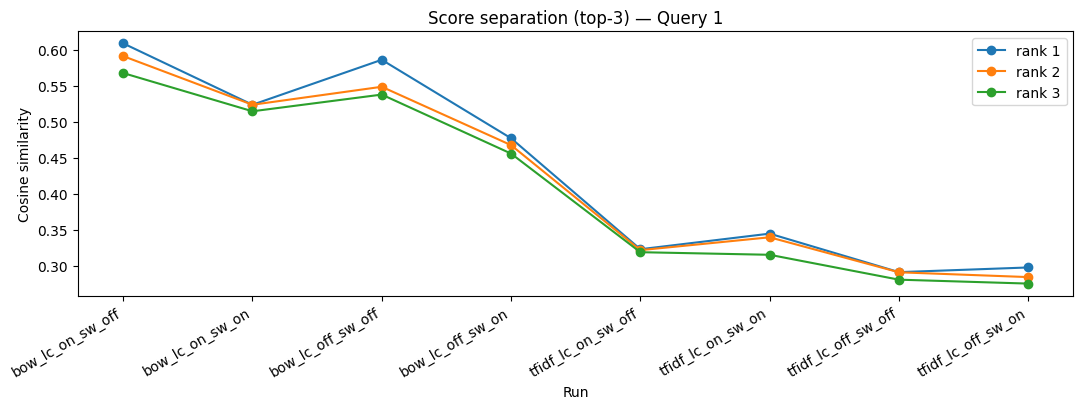

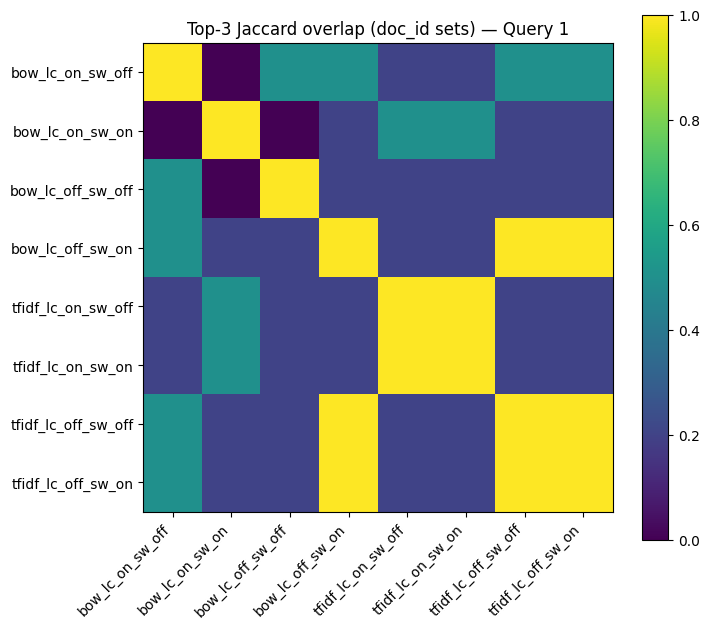

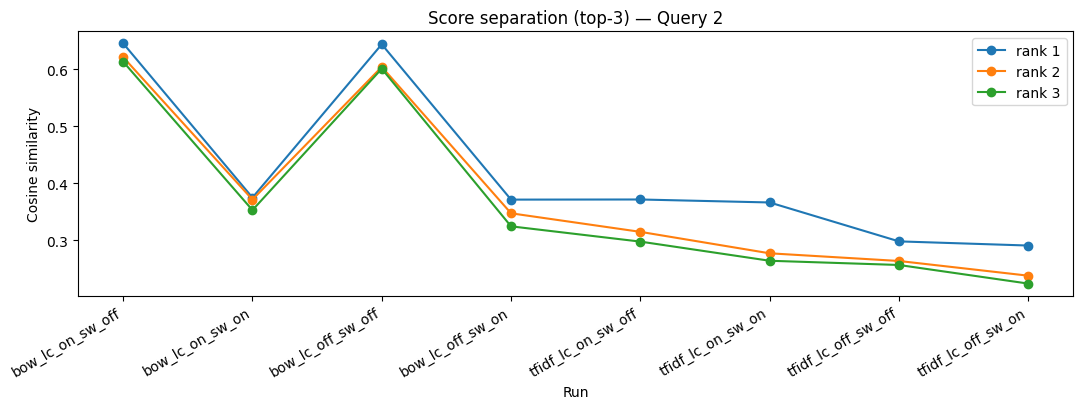

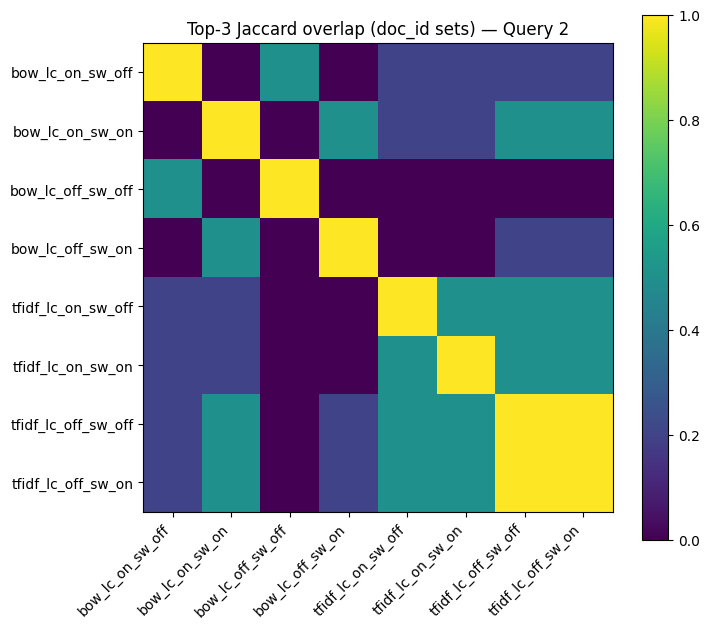

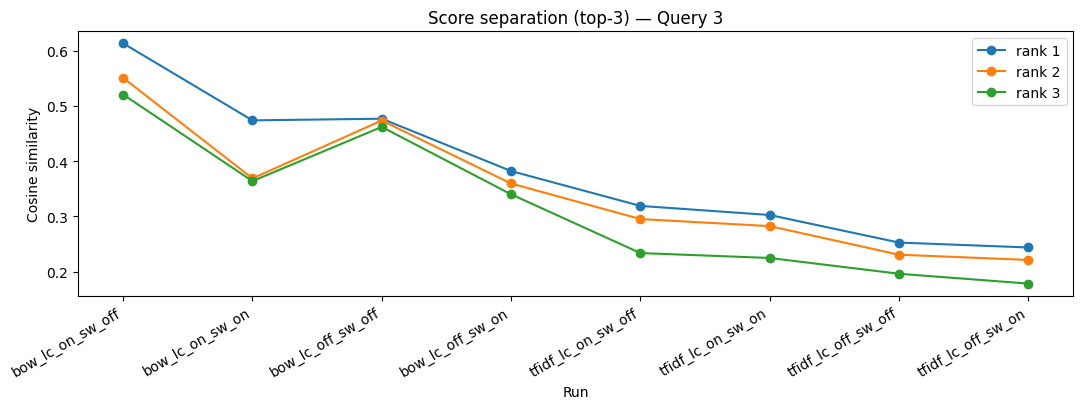

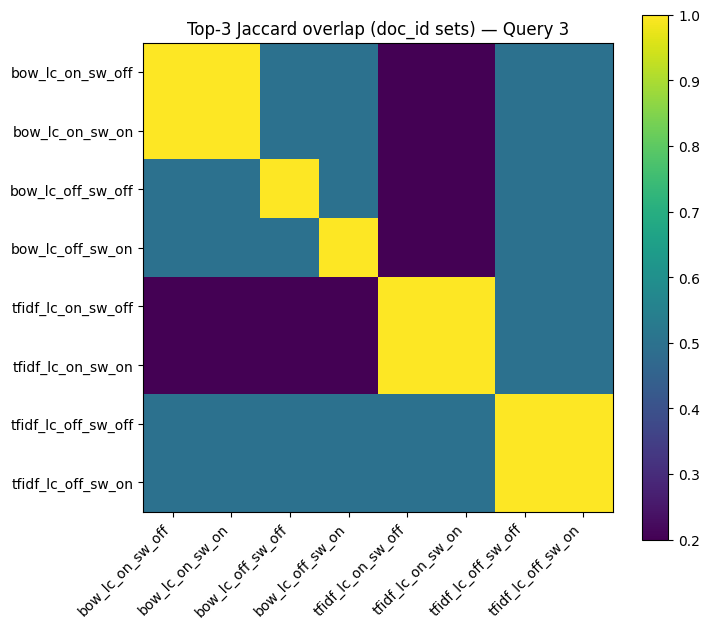

In [92]:
from section8_plots import plot_score_separation, plot_jaccard_heatmap

RUN_ORDER_ALL = RUN_ORDER_BOW + RUN_ORDER_TFIDF

for q in query_labels:
    # (A) score separation across all 8 runs
    plot_score_separation(results_df, query_label=q, run_order=RUN_ORDER_ALL, repr_filter=None)

    # (B) stability/overlap across all 8 runs (top-3 doc_id sets)
    plot_jaccard_heatmap(results_df, query_label=q, run_order=RUN_ORDER_ALL, repr_filter=None, k=3)


c:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TPLN\tpln-practice1\code\lvl1\lvl2\tpln-practice-code\section8_plots.py:264: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("repr")["doc_id"]


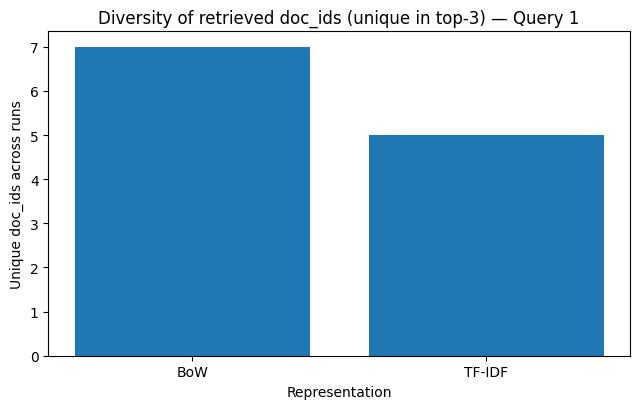

c:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TPLN\tpln-practice1\code\lvl1\lvl2\tpln-practice-code\section8_plots.py:264: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("repr")["doc_id"]


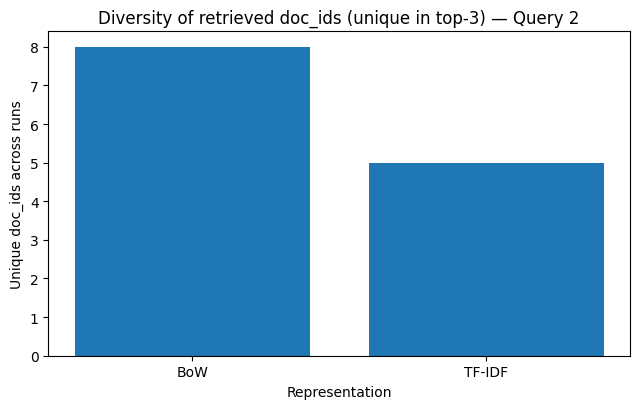

c:\Users\Cris-SX\Desktop\UA\CHAD-MASTER-IA\TPLN\tpln-practice1\code\lvl1\lvl2\tpln-practice-code\section8_plots.py:264: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("repr")["doc_id"]


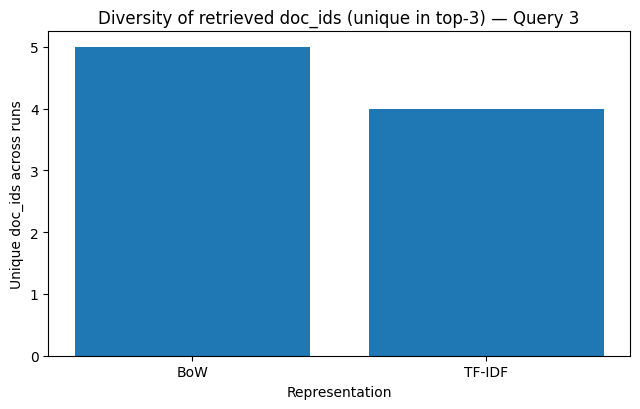

In [93]:
from section8_plots import plot_diversity_bow_vs_tfidf

for q in query_labels:
    plot_diversity_bow_vs_tfidf(results_df, query_label=q, k=3)


## Analysis of the graphs

### Query 1

* **Score-separation plot:** BoW runs show **higher** similarities and a *visible but modest* rank1–rank3 gap, whereas TF-IDF runs sit around **~0.32–0.35** with **rank1/2/3 almost tied**. This visually strengthens the idea that **TF-IDF’s ordering for Q1 is “fragile”** (many near-ties), beyond what we could infer from a table alone.
* **Jaccard heatmap:** It looks **block-structured**: TF-IDF variants overlap strongly with each other, but BoW variants overlap less consistently—especially across **sw_off vs sw_on**. So, for Q1, *preprocessing toggles matter more for BoW’s retrieved set than for TF-IDF’s*.
* **Diversity bar chart:** **BoW = 7 unique doc_ids vs TF-IDF = 5** (across runs, within top-3). This quantifies that Q1’s BoW retrieval is **less stable/more variable** than TF-IDF, even if both stay in the broad MT/evaluation neighborhood.

### Query 2

* **Score-separation plot:** BoW with **stopwords off** has the strongest top-3 scores (rank1 near the top of the figure), but switching to **stopwords on** causes a **sharp drop** and compresses scores. This matches a *qualitative regime change*: the retrieval is not just “slightly different,” it becomes **materially weaker / reoriented** under that toggle.
* **Jaccard heatmap:** The clearest pattern is a **near-split** between BoW sw_off and BoW sw_on (very low overlap between those two groups), while TF-IDF configs show **moderate overlap** (some pairs high, some mid). In other words: **Query 2 is the most preprocessing-sensitive query under BoW**, and the heatmap makes that sensitivity explicit.
* **Diversity bar chart:** **BoW = 8 vs TF-IDF = 5** unique doc_ids. This is our strongest numeric evidence that Q2’s BoW top-3 is **the least stable** across preprocessing choices.

### Query 3

* **Score-separation plot:** Scores change with preprocessing, but not always because the *documents* change.
* **Jaccard heatmap:**within BoW, **sw_off vs sw_on overlaps are ~1.0** (same top-3 doc_id set) in both lc_on and lc_off cases. So for Q3, stopword toggling mostly affects **cosine magnitudes/ranking margins**, not the identity of retrieved documents. TF-IDF also shows very high internal overlap by pairs, while **BoW vs TF-IDF overlap is low**, indicating that **representation choice dominates** (they retrieve different top-3 sets even when each family is internally stable).
* **Diversity bar chart:** **BoW = 5 vs TF-IDF = 4** unique doc_ids, the smallest gap and lowest totals: Q3 is our **most stable query overall** across runs.


## Part 2:

In this section students should use `setence-embeddings` to obtain sentence-embedding representations of the dataset and to peform searches for best matches regarding the examples proposed in the instructions of the assignment.

###Step 1: Trying a general purpose small monolingual model

###Step 2: Comparing other models

###Step 3: Moving to a multilingual environment

When trying multilingual models, you will have to build a multilingual collection of papers. To do so, extend the collection of papers from the EMNLP conference used in the first part of this notebook with an extra collection of papers from the SEPLN conference, which are both in English and Spanish. Create a new dataset that concatenates both collections to try a multilingual search. The collection of SEPLN papers can be downloaded from [https://www.dlsi.ua.es/~mespla/sepln.json](https://www.dlsi.ua.es/~mespla/sepln.json)

##Concluding remarks